<a href="https://colab.research.google.com/github/sourcecode369/100-days-of-ml-code/blob/master/Activity_Log_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving Activitylog.csv to Activitylog.csv


{'Activitylog.csv': b"'activityid','userid','goccode','country','clientinfo','serverinfo','applicationname','perspectiveid','viewid','elementid','actionid','actiondetail','loggedfrom','lastupdate','responsetime','customizedinfo'\r\n1,'vd89220','31182622','IN','IE 11.0','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','RelationshipGridForTreeLayoutHandler.onload','Dashboard-Relationship-Utilization','com.citi.risk.icg.limitexposure.ui.dashboard.element.grid.handler.RelationshipGridForTreeLayoutHandler','2019-07-02 00:02:58.000',1328,\r\n2,'vd89220','31182622','IN','IE 11.0','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','RelationshipGridForTreeLayoutHandler.onload','Dashboard-Relationship-Utilization','com.citi.risk.icg.limitexposure.ui.dashboard.element.grid.handler.RelationshipGridForTreeLayoutHandler','2019-07-02 00:03:00.000',1247,\r\n3,'vd89220','31182622','IN','IE 11.0','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','RelationshipGridForTreeLayoutHandler.on

In [2]:
!ls -Gflash --color

total 352K
4.0K drwxr-xr-x 1 root 4.0K Mar 23 16:11 .config
4.0K drwxr-xr-x 1 root 4.0K Mar 25 11:42 ..
4.0K drwxr-xr-x 1 root 4.0K Mar 25 11:43 .
336K -rw-r--r-- 1 root 333K Mar 25 11:43 Activitylog.csv
4.0K drwxr-xr-x 1 root 4.0K Mar 18 16:23 sample_data


In [0]:
from __future__ import absolute_import, print_function, unicode_literals, division
from builtins import range, input

In [4]:
!pip install imageio
!pip install chart_studio
!pip install missingno
!pip install tqdm

     |████████████████████████████████| 81kB 5.1MB/s 


In [5]:
# import libraries
%%time
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import os
import gc
gc.enable()
import sys
import csv
import glob
import json

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.offline as pyo
import plotly.graph_objs as go
import chart_studio.plotly as py

plt.rc('font', size=12) 
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=12) 
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12) 
plt.rc('legend', fontsize=12) 
plt.rc('figure', titlesize=14) 
plt.rcParams['figure.dpi'] = 60
sns.set(rc={"figure.figsize":(12,10)})
sns.set_style("whitegrid")
sns.set_context("notebook")
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

import datetime
import multiprocessing
import missingno as msno 
from tqdm import tqdm_notebook

import warnings
warnings.simplefilter('ignore')

CPU times: user 552 ms, sys: 117 ms, total: 669 ms
Wall time: 1.37 s


In [0]:
# function to display summary statistics
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [0]:
# reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [157]:
# using multiprocessing, reducing memory usage and glob to read files
files = glob.glob("*.csv")

def load_data(file):
    col_names = ["activityid",
                 "userid",
                "goccode",
                "country",
                "clientinfo",
                "serverinfo",
                "applicationname",
                "perspectiveid",
                "viewid",
                "elementid",
                "actionid",
                "actiondetail",
                "loggedfrom",
                "lastupdate",
                "responsetime",
                "customizedinfo"]
    return reduce_mem_usage(pd.read_csv(file,names=col_names).drop(0).reset_index(drop=True))

with multiprocessing.Pool() as pool:
    df = pool.map(load_data, files)[0]

df = df.drop("activityid",axis=1)
print(df.shape)

Mem. usage decreased to  0.14 Mb (0.0% reduction)
(1123, 15)


In [0]:
# utility function for displaying data
from IPython.display import display, clear_output
def display_df(df):
  with pd.option_context("display.max_rows",10,"display.max_columns",100):
    display(df)

In [159]:
display_df(df)

,userid,goccode,country,clientinfo,serverinfo,applicationname,perspectiveid,viewid,elementid,actionid,actiondetail,loggedfrom,lastupdate,responsetime,customizedinfo
0,'vd89220','31182622','IN','IE 11.0','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','RelationshipGridForTreeLayoutHandler.onload','Dashboard-Relationship-Utilization','com.citi.risk.icg.limitexposure.ui.dashboard....,'2019-07-02 00:02:58.000',1328,NaN
1,'vd89220','31182622','IN','IE 11.0','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','RelationshipGridForTreeLayoutHandler.onload','Dashboard-Relationship-Utilization','com.citi.risk.icg.limitexposure.ui.dashboard....,'2019-07-02 00:03:00.000',1247,NaN
2,'vd89220','31182622','IN','IE 11.0','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','RelationshipGridForTreeLayoutHandler.onload','Dashboard-Relationship-Utilization','com.citi.risk.icg.limitexposure.ui.dashboard....,'2019-07-02 00:03:21.000',1023,NaN
3,'vd89220','31182622','IN','IE 11.0','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','PortfolioSummaryGridForTreeLayoutHandler.onLoad','RiskManager-Dashboard','com.citi.risk.icg.limitexposure.ui.dashboard....,'2019-07-02 00:03:32.000',1332,NaN
4,'vd89220','31182622','IN','IE 11.0','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','Top10GridForTreeLayoutHandler.onLoad','RiskManager-Dashboard','com.citi.risk.icg.limitexposure.ui.dashboard....,'2019-07-02 00:03:33.000',1628,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,'nt52152','31186626','IN','Chrome 74.0.3729.131','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','FinancialsHistoryDrillDownHandler.onload','RelationshipView-DrillDown-Financials','com.citi.risk.icg.limitexposure.ui.customer.e...,'2019-07-02 08:17:34.000',30,NaN
1119,'nt52152','31186626','IN','Chrome 74.0.3729.131','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','FinancialsHistoryDrillDownHandler.onload','RelationshipView-DrillDown-Financials','com.citi.risk.icg.limitexposure.ui.customer.e...,'2019-07-02 08:19:00.000',34,NaN
1120,'nt52152','31186626','IN','Chrome 74.0.3729.131','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','FinancialsHistoryDrillDownHandler.onload','RelationshipView-DrillDown-Financials','com.citi.risk.icg.limitexposure.ui.customer.e...,'2019-07-02 08:19:01.000',30,NaN
1121,'kf82774','1871OY7043','PL','Chrome 74.0.3729.131','clmwiemap6u.nam.nsroot.net','Navigator','51758','980013','','storageLoadElementData','application=CRCR; perspective=otc; domain=com...,'com.citi.risk.ui.controller.StorageController','2019-07-02 08:20:11.000',0,NaN


In [0]:
from datetime import datetime
a = df['lastupdate'].astype(str).apply(lambda x: x.split(" ")[0])

In [161]:
resumetable(df)

Dataset Shape: (1123, 15)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,userid,object,0,19,'vd89220','vd89220','vd89220',3.30
1,goccode,object,0,6,'31182622','31182622','31182622',1.33
2,country,object,0,4,'IN','IN','IN',0.62
3,clientinfo,object,0,4,'IE 11.0','IE 11.0','IE 11.0',0.49
4,serverinfo,object,0,1,'clmwiemap6u.nam.nsroot.net','clmwiemap6u.nam.nsroot.net','clmwiemap6u.nam.nsroot.net',0.00
5,applicationname,object,0,6,'CRCRApplication','CRCRApplication','CRCRApplication',1.42
6,perspectiveid,object,0,21,'','','',2.65
7,viewid,object,0,29,'','','',2.95
8,elementid,object,0,15,'','','',0.65
9,actionid,object,0,54,'RelationshipGridForTreeLayoutHandler.onload','RelationshipGridForTreeLayoutHandler.onload','RelationshipGridForTreeLayoutHandler.onload',4.50


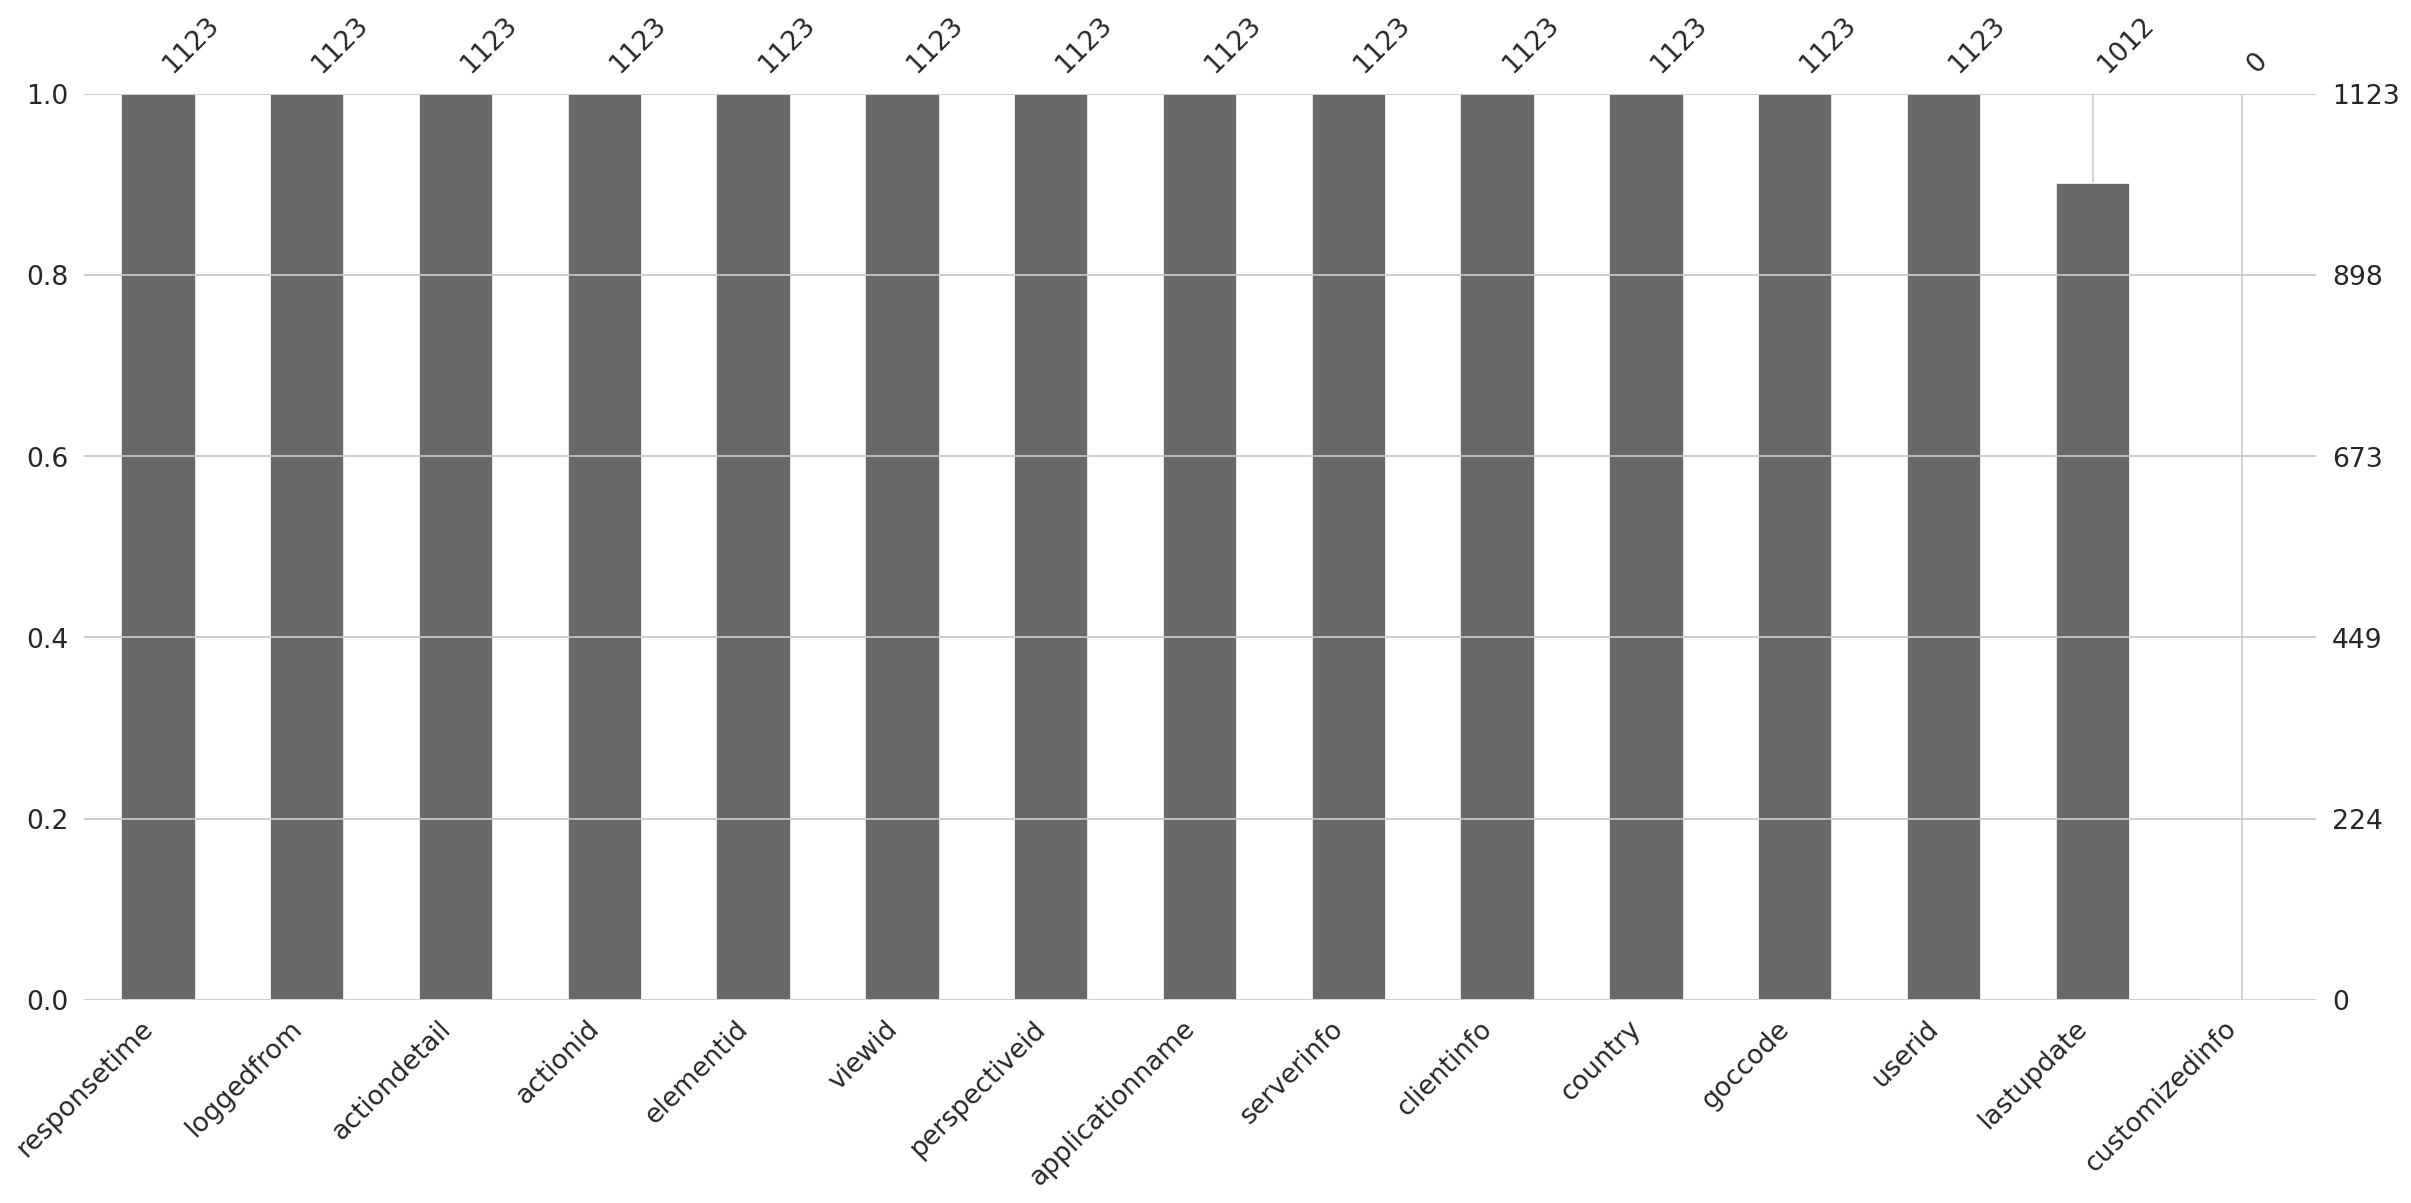

In [162]:
# check missing values
msno.bar(df, sort='descending')

In [0]:
# drop data with missing values below a certain threshold - (0.7)
df_raw = df.loc[:, list(df.columns[df.isnull().sum().sort_values()/len(df)<0.7])]

In [164]:
display_df(df_raw)

,userid,goccode,country,clientinfo,serverinfo,applicationname,perspectiveid,viewid,elementid,actionid,actiondetail,loggedfrom,lastupdate,responsetime
0,'vd89220','31182622','IN','IE 11.0','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','RelationshipGridForTreeLayoutHandler.onload','Dashboard-Relationship-Utilization','com.citi.risk.icg.limitexposure.ui.dashboard....,'2019-07-02 00:02:58.000',1328
1,'vd89220','31182622','IN','IE 11.0','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','RelationshipGridForTreeLayoutHandler.onload','Dashboard-Relationship-Utilization','com.citi.risk.icg.limitexposure.ui.dashboard....,'2019-07-02 00:03:00.000',1247
2,'vd89220','31182622','IN','IE 11.0','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','RelationshipGridForTreeLayoutHandler.onload','Dashboard-Relationship-Utilization','com.citi.risk.icg.limitexposure.ui.dashboard....,'2019-07-02 00:03:21.000',1023
3,'vd89220','31182622','IN','IE 11.0','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','PortfolioSummaryGridForTreeLayoutHandler.onLoad','RiskManager-Dashboard','com.citi.risk.icg.limitexposure.ui.dashboard....,'2019-07-02 00:03:32.000',1332
4,'vd89220','31182622','IN','IE 11.0','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','Top10GridForTreeLayoutHandler.onLoad','RiskManager-Dashboard','com.citi.risk.icg.limitexposure.ui.dashboard....,'2019-07-02 00:03:33.000',1628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,'nt52152','31186626','IN','Chrome 74.0.3729.131','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','FinancialsHistoryDrillDownHandler.onload','RelationshipView-DrillDown-Financials','com.citi.risk.icg.limitexposure.ui.customer.e...,'2019-07-02 08:17:34.000',30
1119,'nt52152','31186626','IN','Chrome 74.0.3729.131','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','FinancialsHistoryDrillDownHandler.onload','RelationshipView-DrillDown-Financials','com.citi.risk.icg.limitexposure.ui.customer.e...,'2019-07-02 08:19:00.000',34
1120,'nt52152','31186626','IN','Chrome 74.0.3729.131','clmwiemap6u.nam.nsroot.net','CRCRApplication','','','','FinancialsHistoryDrillDownHandler.onload','RelationshipView-DrillDown-Financials','com.citi.risk.icg.limitexposure.ui.customer.e...,'2019-07-02 08:19:01.000',30
1121,'kf82774','1871OY7043','PL','Chrome 74.0.3729.131','clmwiemap6u.nam.nsroot.net','Navigator','51758','980013','','storageLoadElementData','application=CRCR; perspective=otc; domain=com...,'com.citi.risk.ui.controller.StorageController','2019-07-02 08:20:11.000',0


In [101]:
display_df(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 14 columns):
userid             1124 non-null object
goccode            1124 non-null object
country            1124 non-null object
clientinfo         1124 non-null object
serverinfo         1124 non-null object
applicationname    1124 non-null object
perspectiveid      1124 non-null object
viewid             1124 non-null object
elementid          1124 non-null object
actionid           1124 non-null object
actiondetail       1124 non-null object
loggedfrom         1124 non-null object
lastupdate         1013 non-null object
responsetime       1124 non-null object
dtypes: object(14)
memory usage: 123.1+ KB


None

In [102]:
display_df(df_raw.describe(include="all").T)

,count,unique,top,freq
userid,1124,20,'as46669',338
goccode,1124,7,'500056932',807
country,1124,5,'IN',989
clientinfo,1124,5,'Chrome 74.0.3729.131',1042
serverinfo,1124,2,'clmwiemap6u.nam.nsroot.net',1123
...,...,...,...,...
actionid,1124,55,'storageLoadElementData',214
actiondetail,1124,77,'application=CRCR; perspective=crcr',77
loggedfrom,1124,36,'com.citi.risk.ui.controller.StorageController',357
lastupdate,1013,804,'2019-07-02 06:57:18.000',6


In [0]:
# data cleaning
df_raw["userid"] = df_raw["userid"].apply(lambda x: x.split()[0])
df_raw[df_raw.columns[df_raw.isna().sum() != 0]] = df_raw[df_raw.columns[df_raw.isna().sum() != 0]].fillna(0)
df_raw["lastupdate"] = pd.to_datetime(df_raw["lastupdate"].astype(str),errors="ignore",format="%m/%d/%Y %H:%M:%S")
df_raw["responsetime"] = pd.to_numeric(df_raw["responsetime"])

In [0]:
columns = list(df_raw.columns)
remove_columns = ["serverinfo",
 "perspectiveid",
 "viewid",
 "elementid",
 "actionid",
 "loggedfrom",
 "lastupdate",
 "responsetime"]
display_columns = [i for i in columns if i not in remove_columns]

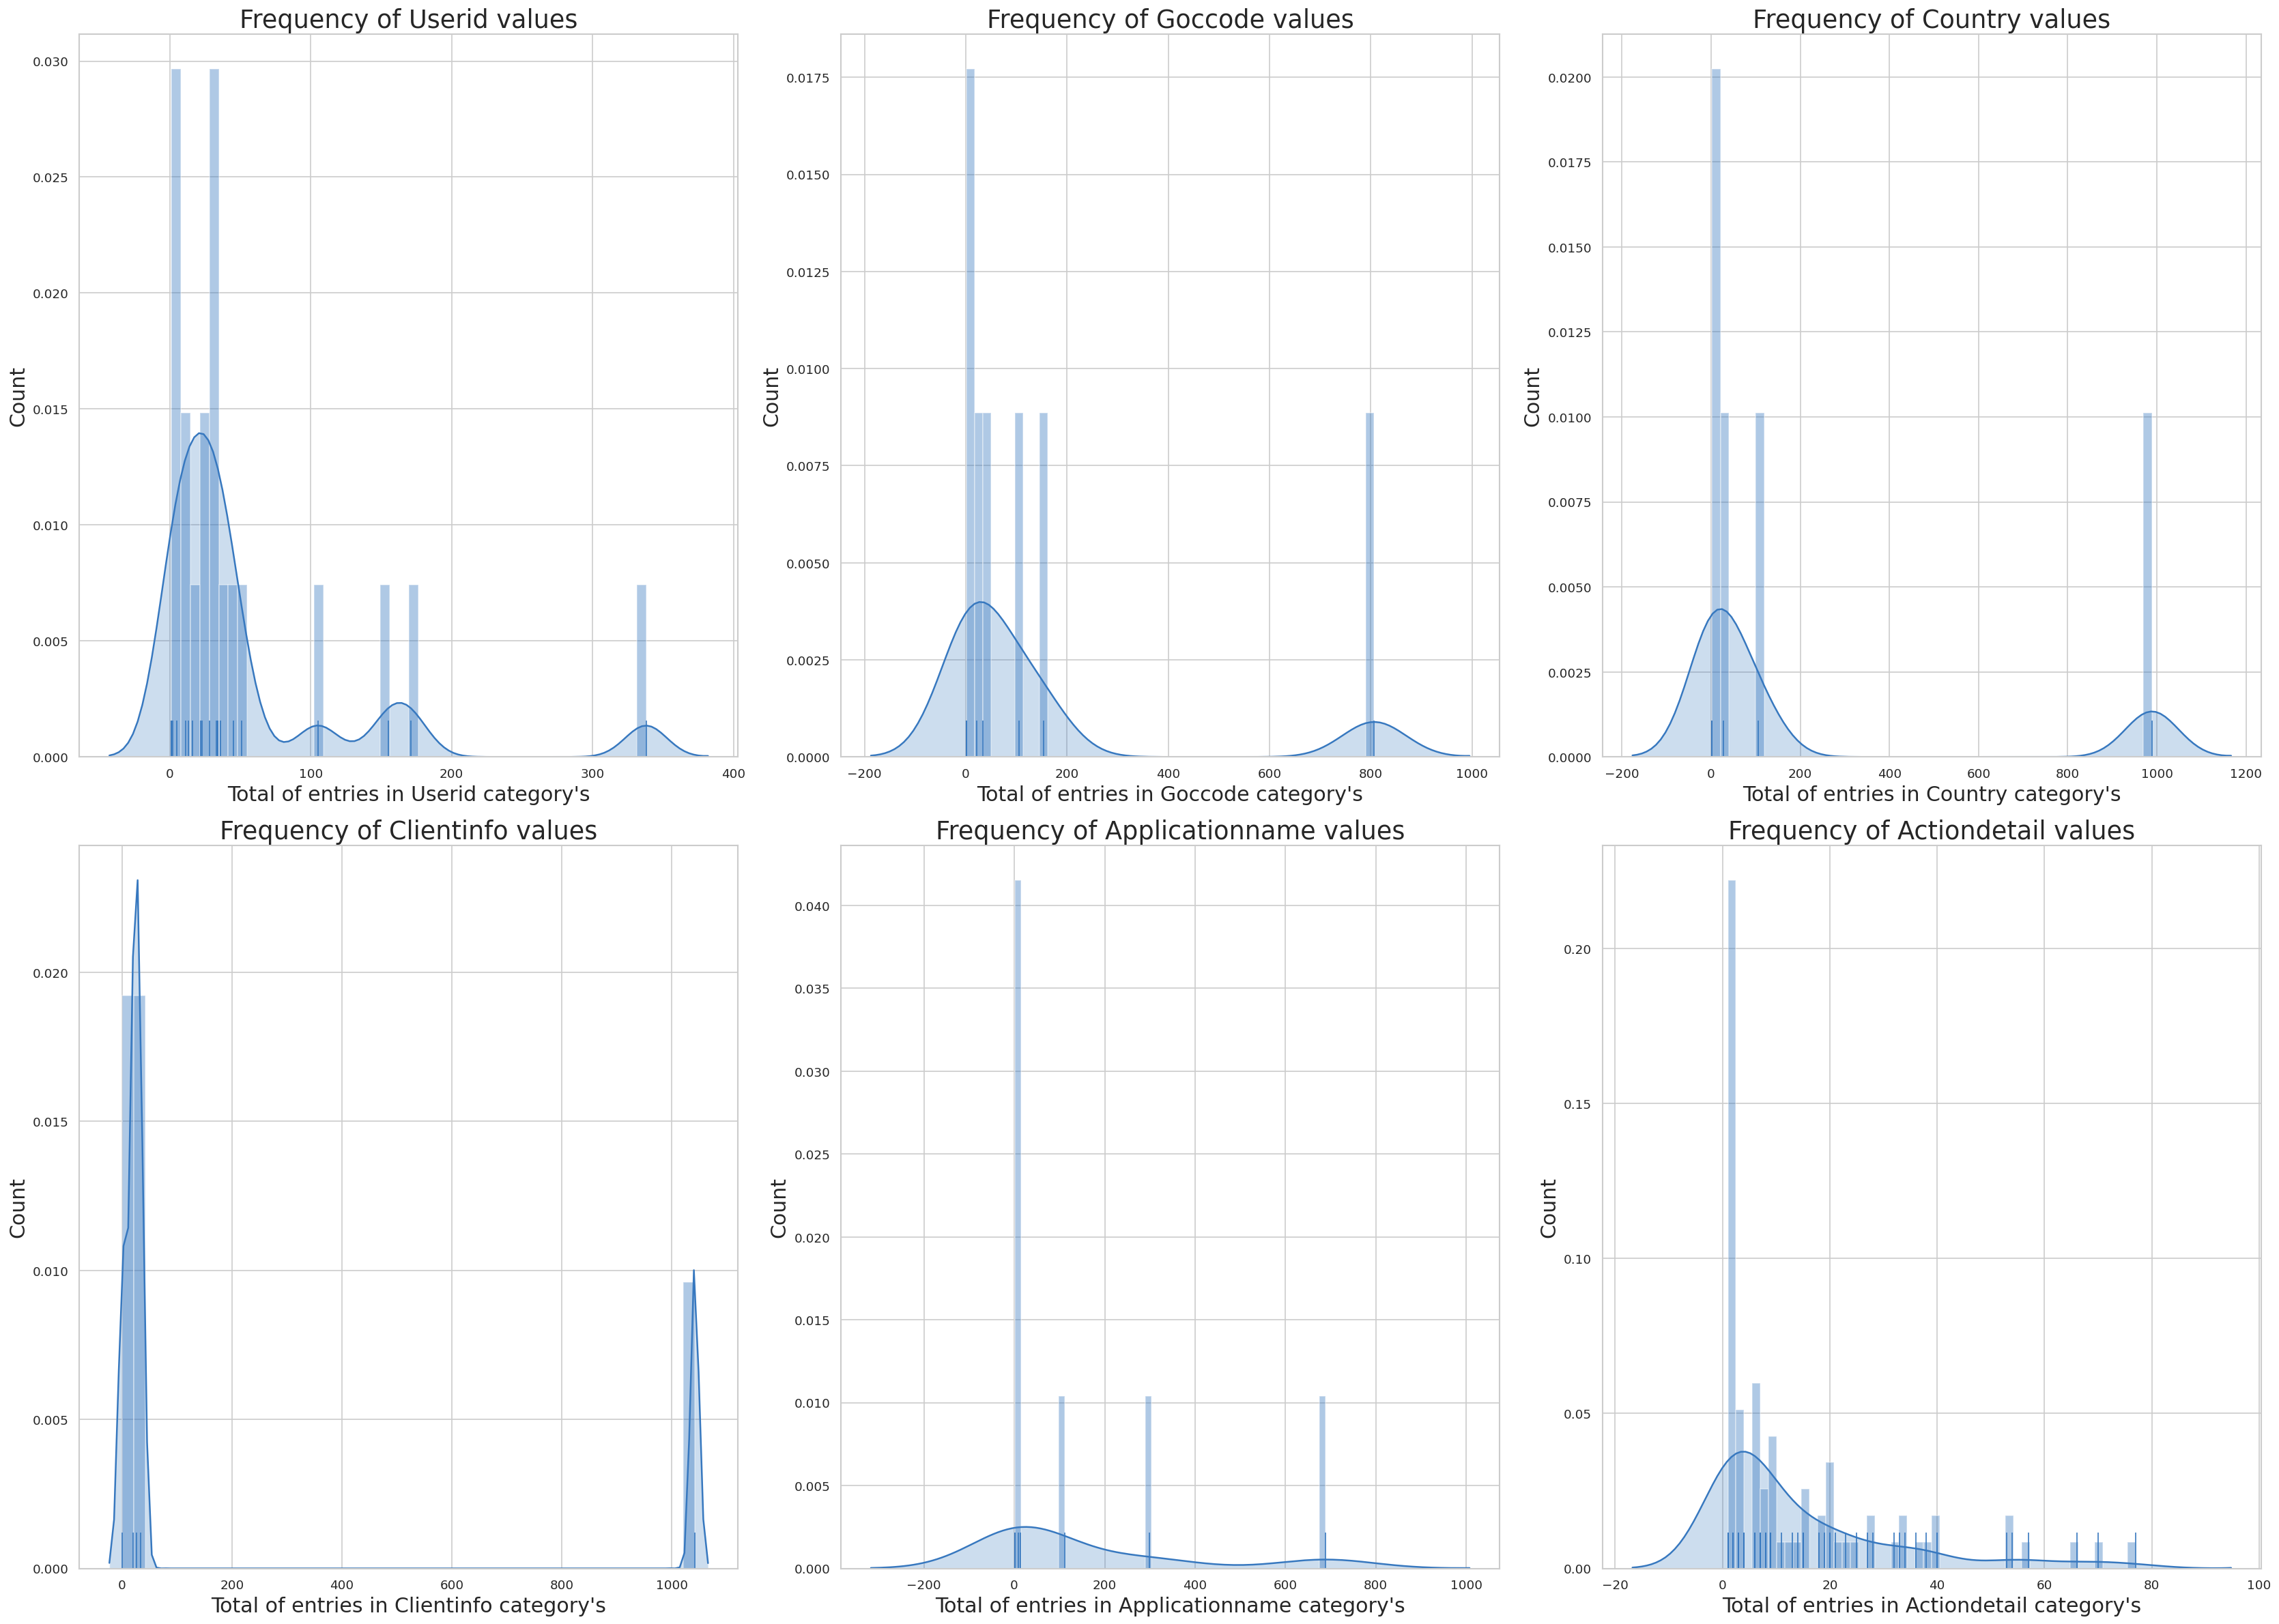

In [129]:
# distribution of values
import matplotlib.gridspec as gridspec 
grid = gridspec.GridSpec(2, 3) 
total = len(df_raw)
plt.figure(figsize=(28,20)) 
for n, col in enumerate(df_raw[display_columns]): 
  name = display_columns[n].replace("'","").capitalize()
  ax = plt.subplot(grid[n])
  app = df_raw[f"{display_columns[n]}"].value_counts().reset_index()[f"{display_columns[n]}"].values
  sns.distplot(app, bins= 50, rug=True,
             kde_kws={'shade':True})
  ax.set_title(f"Frequency of {name} values", fontsize=22)
  ax.set_xlabel(f"Total of entries in {name} category's", fontsize=18)
  ax.set_ylabel("Count", fontsize=18)
plt.tight_layout()
plt.show()

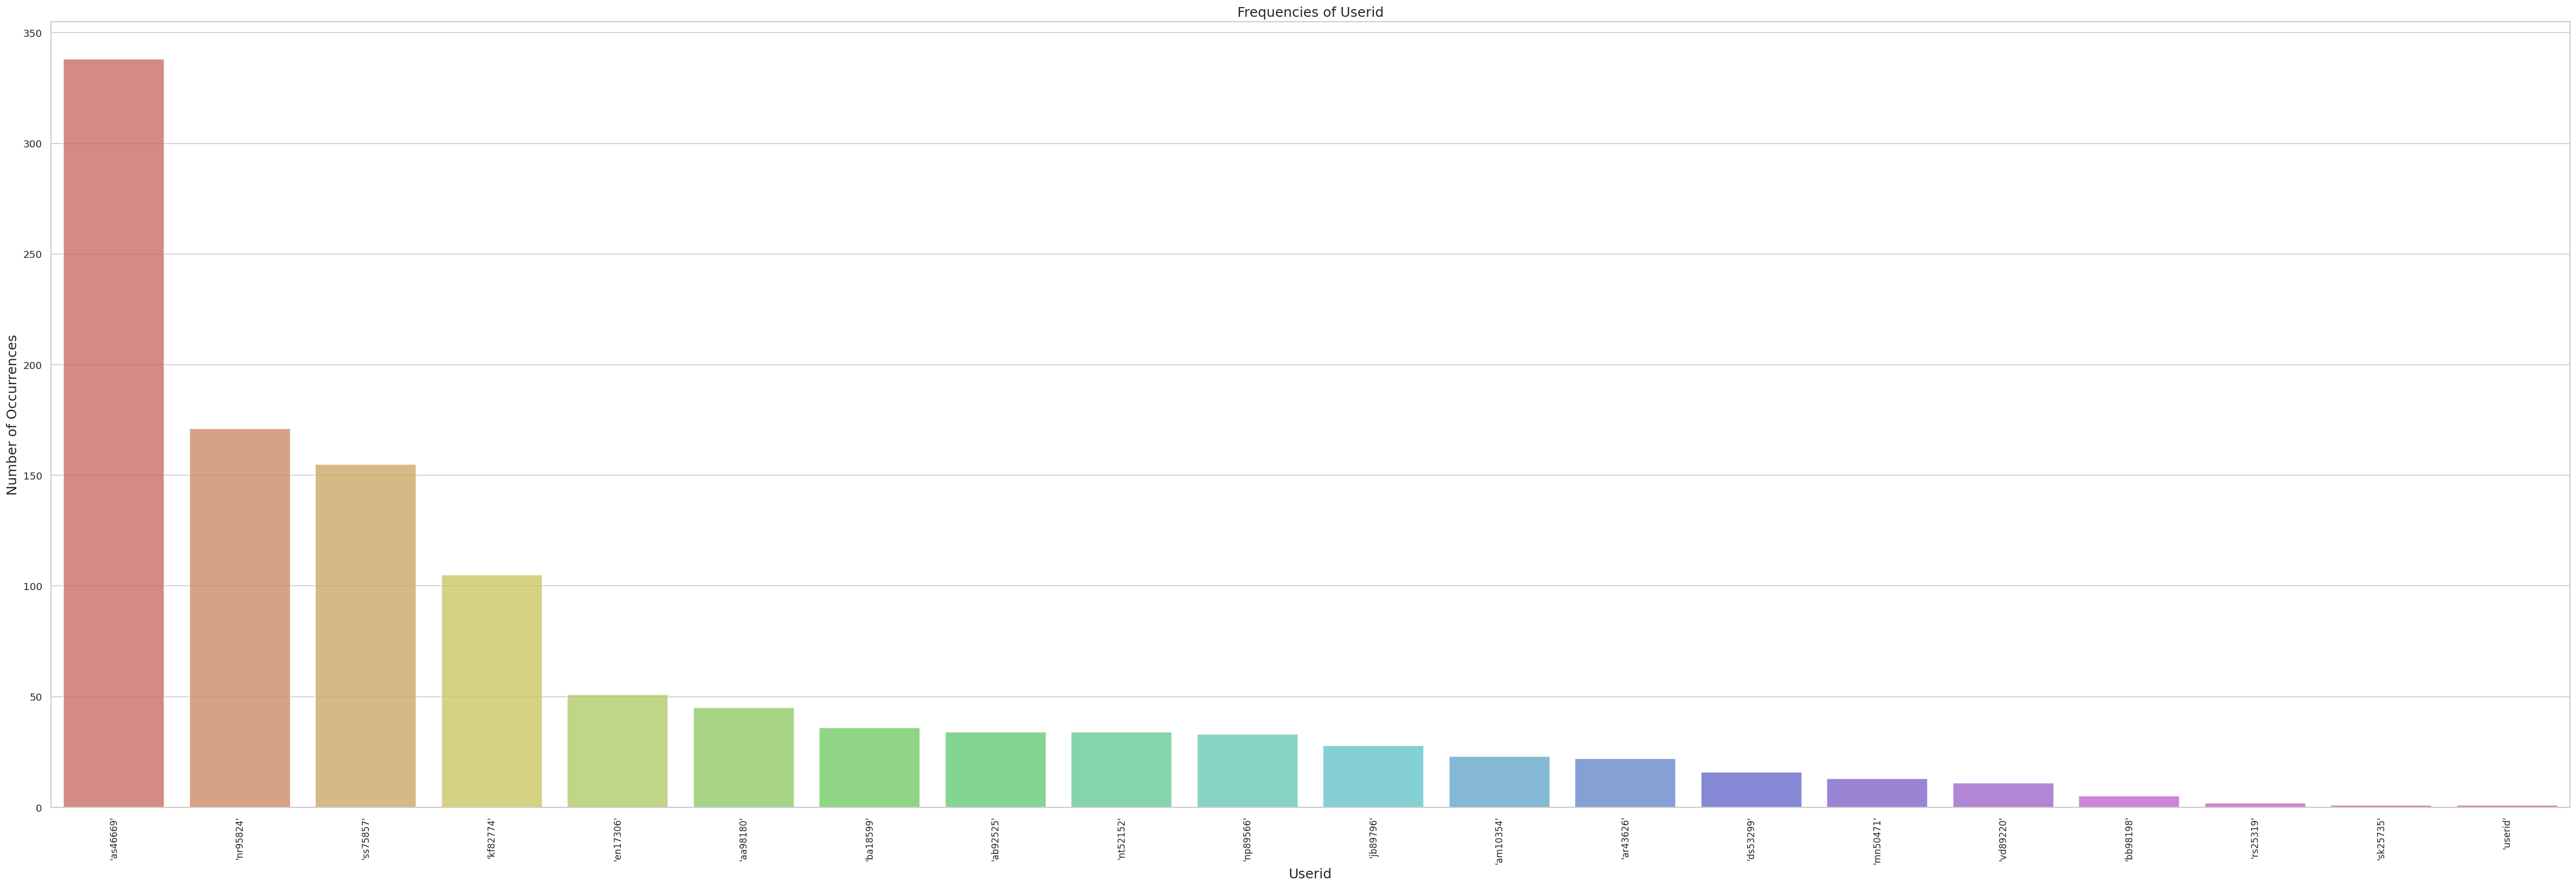

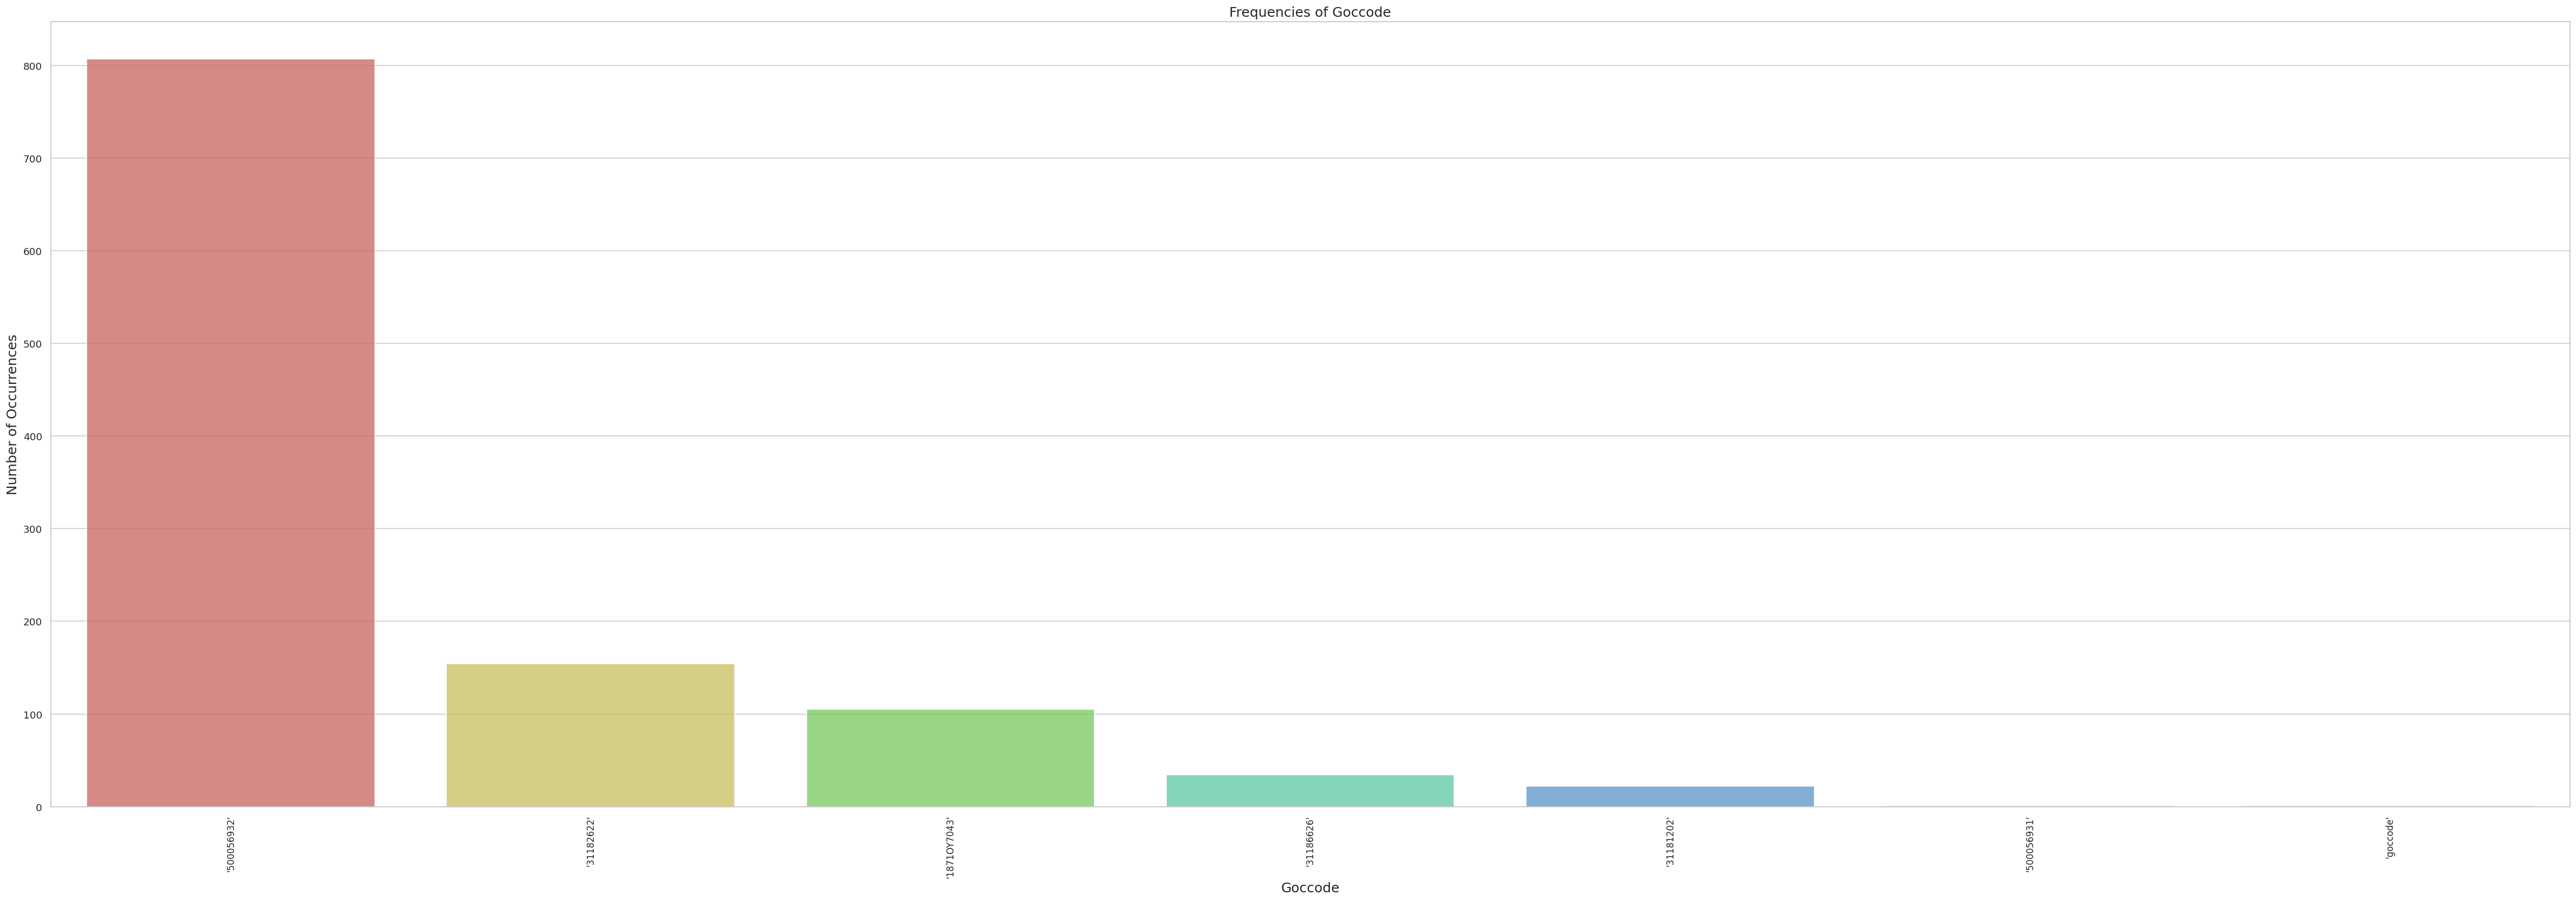

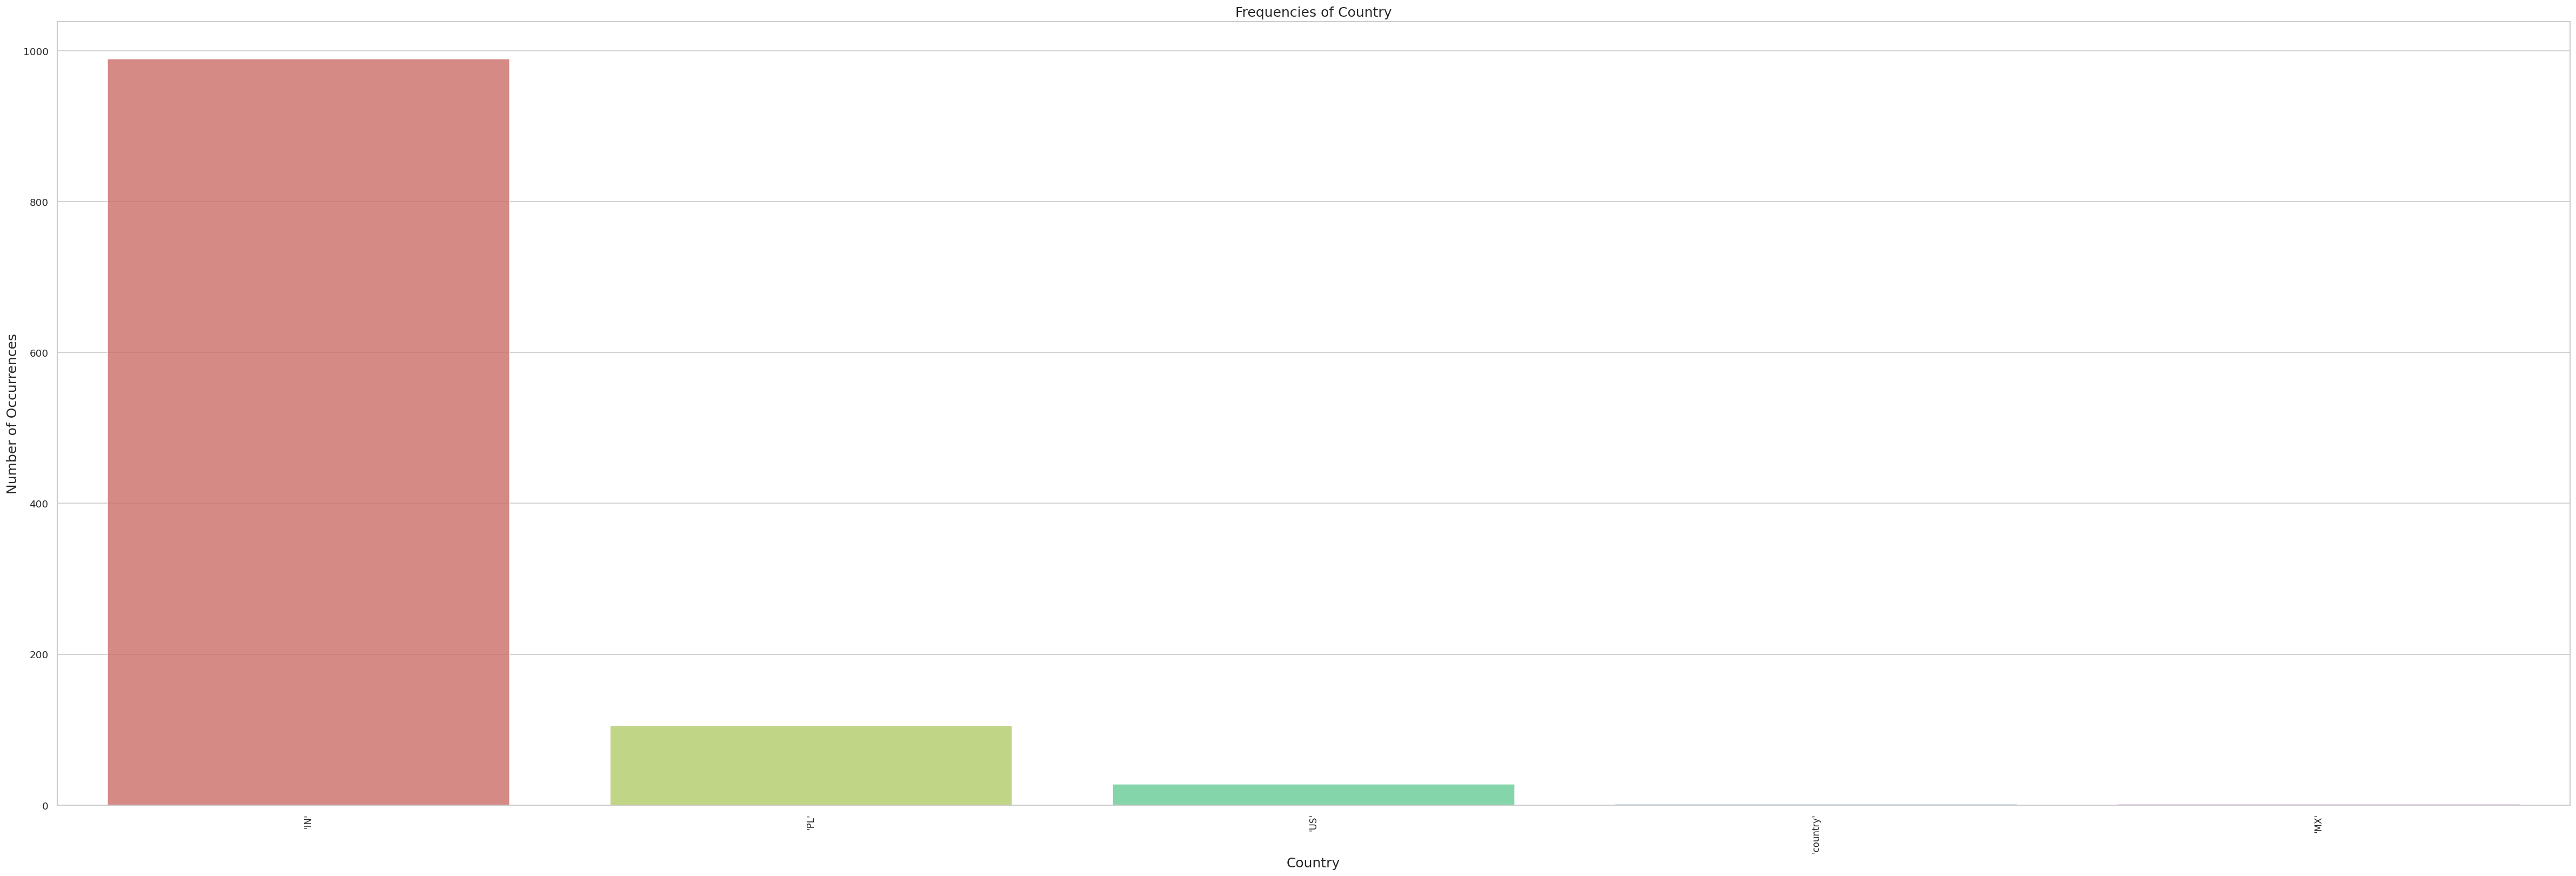

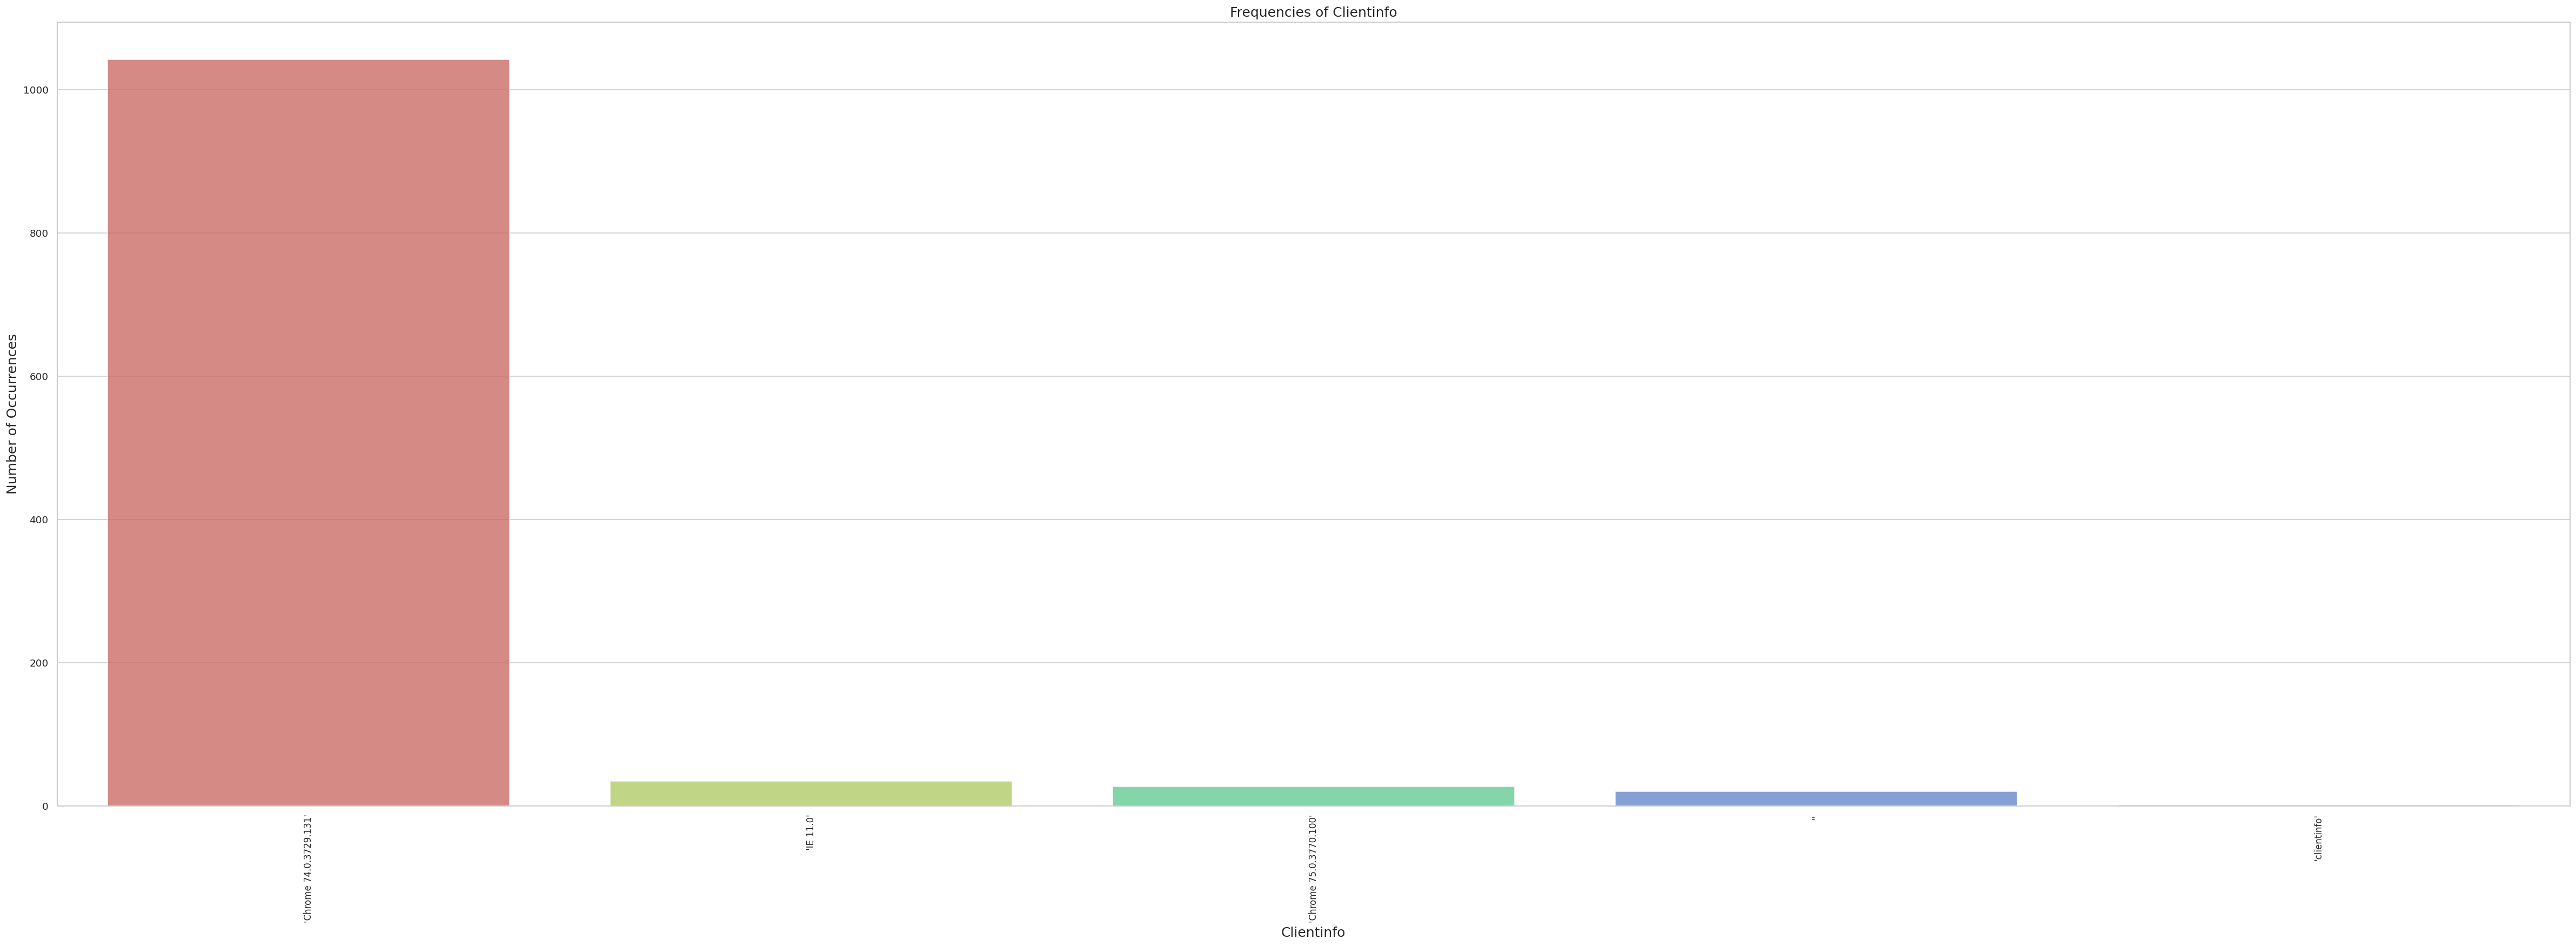

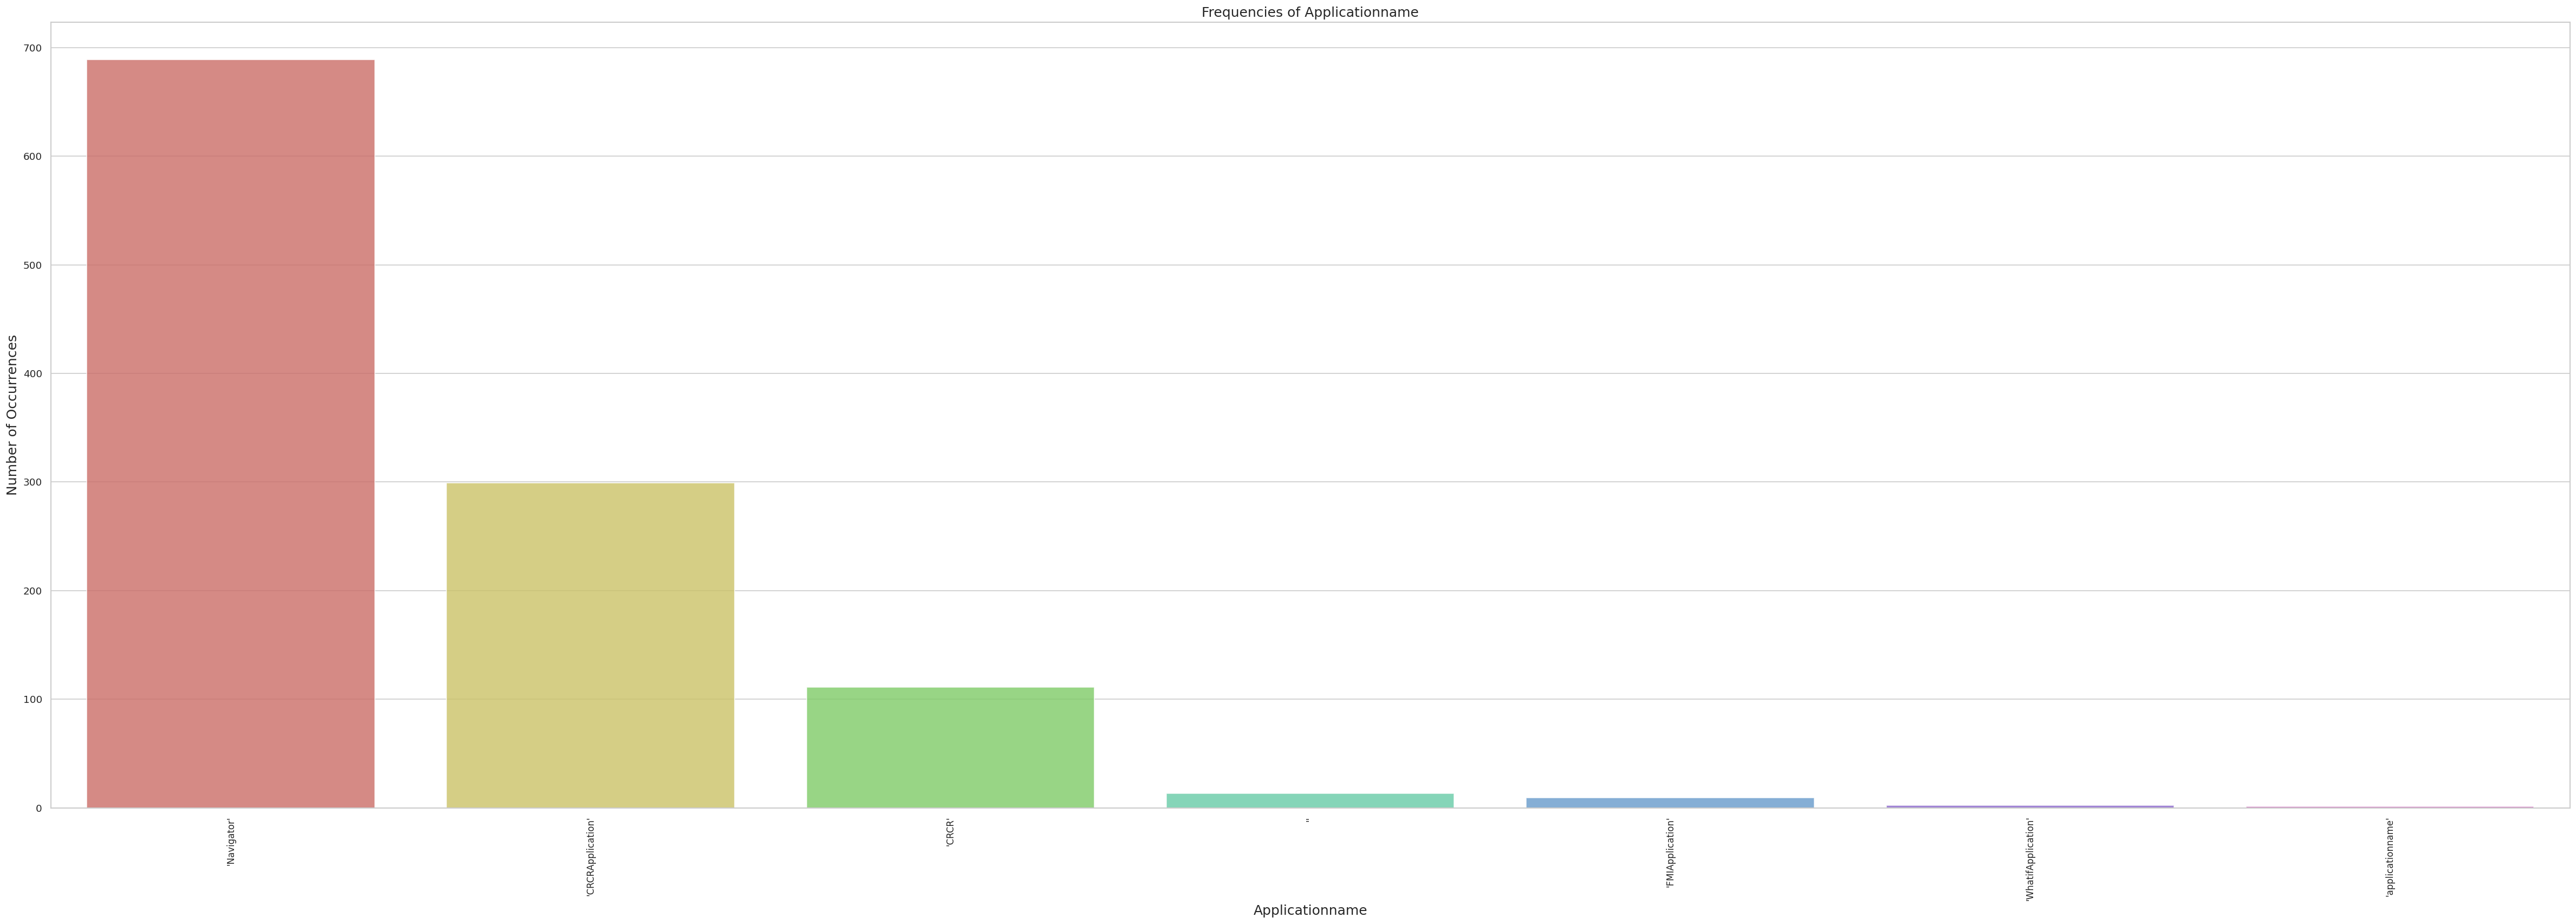

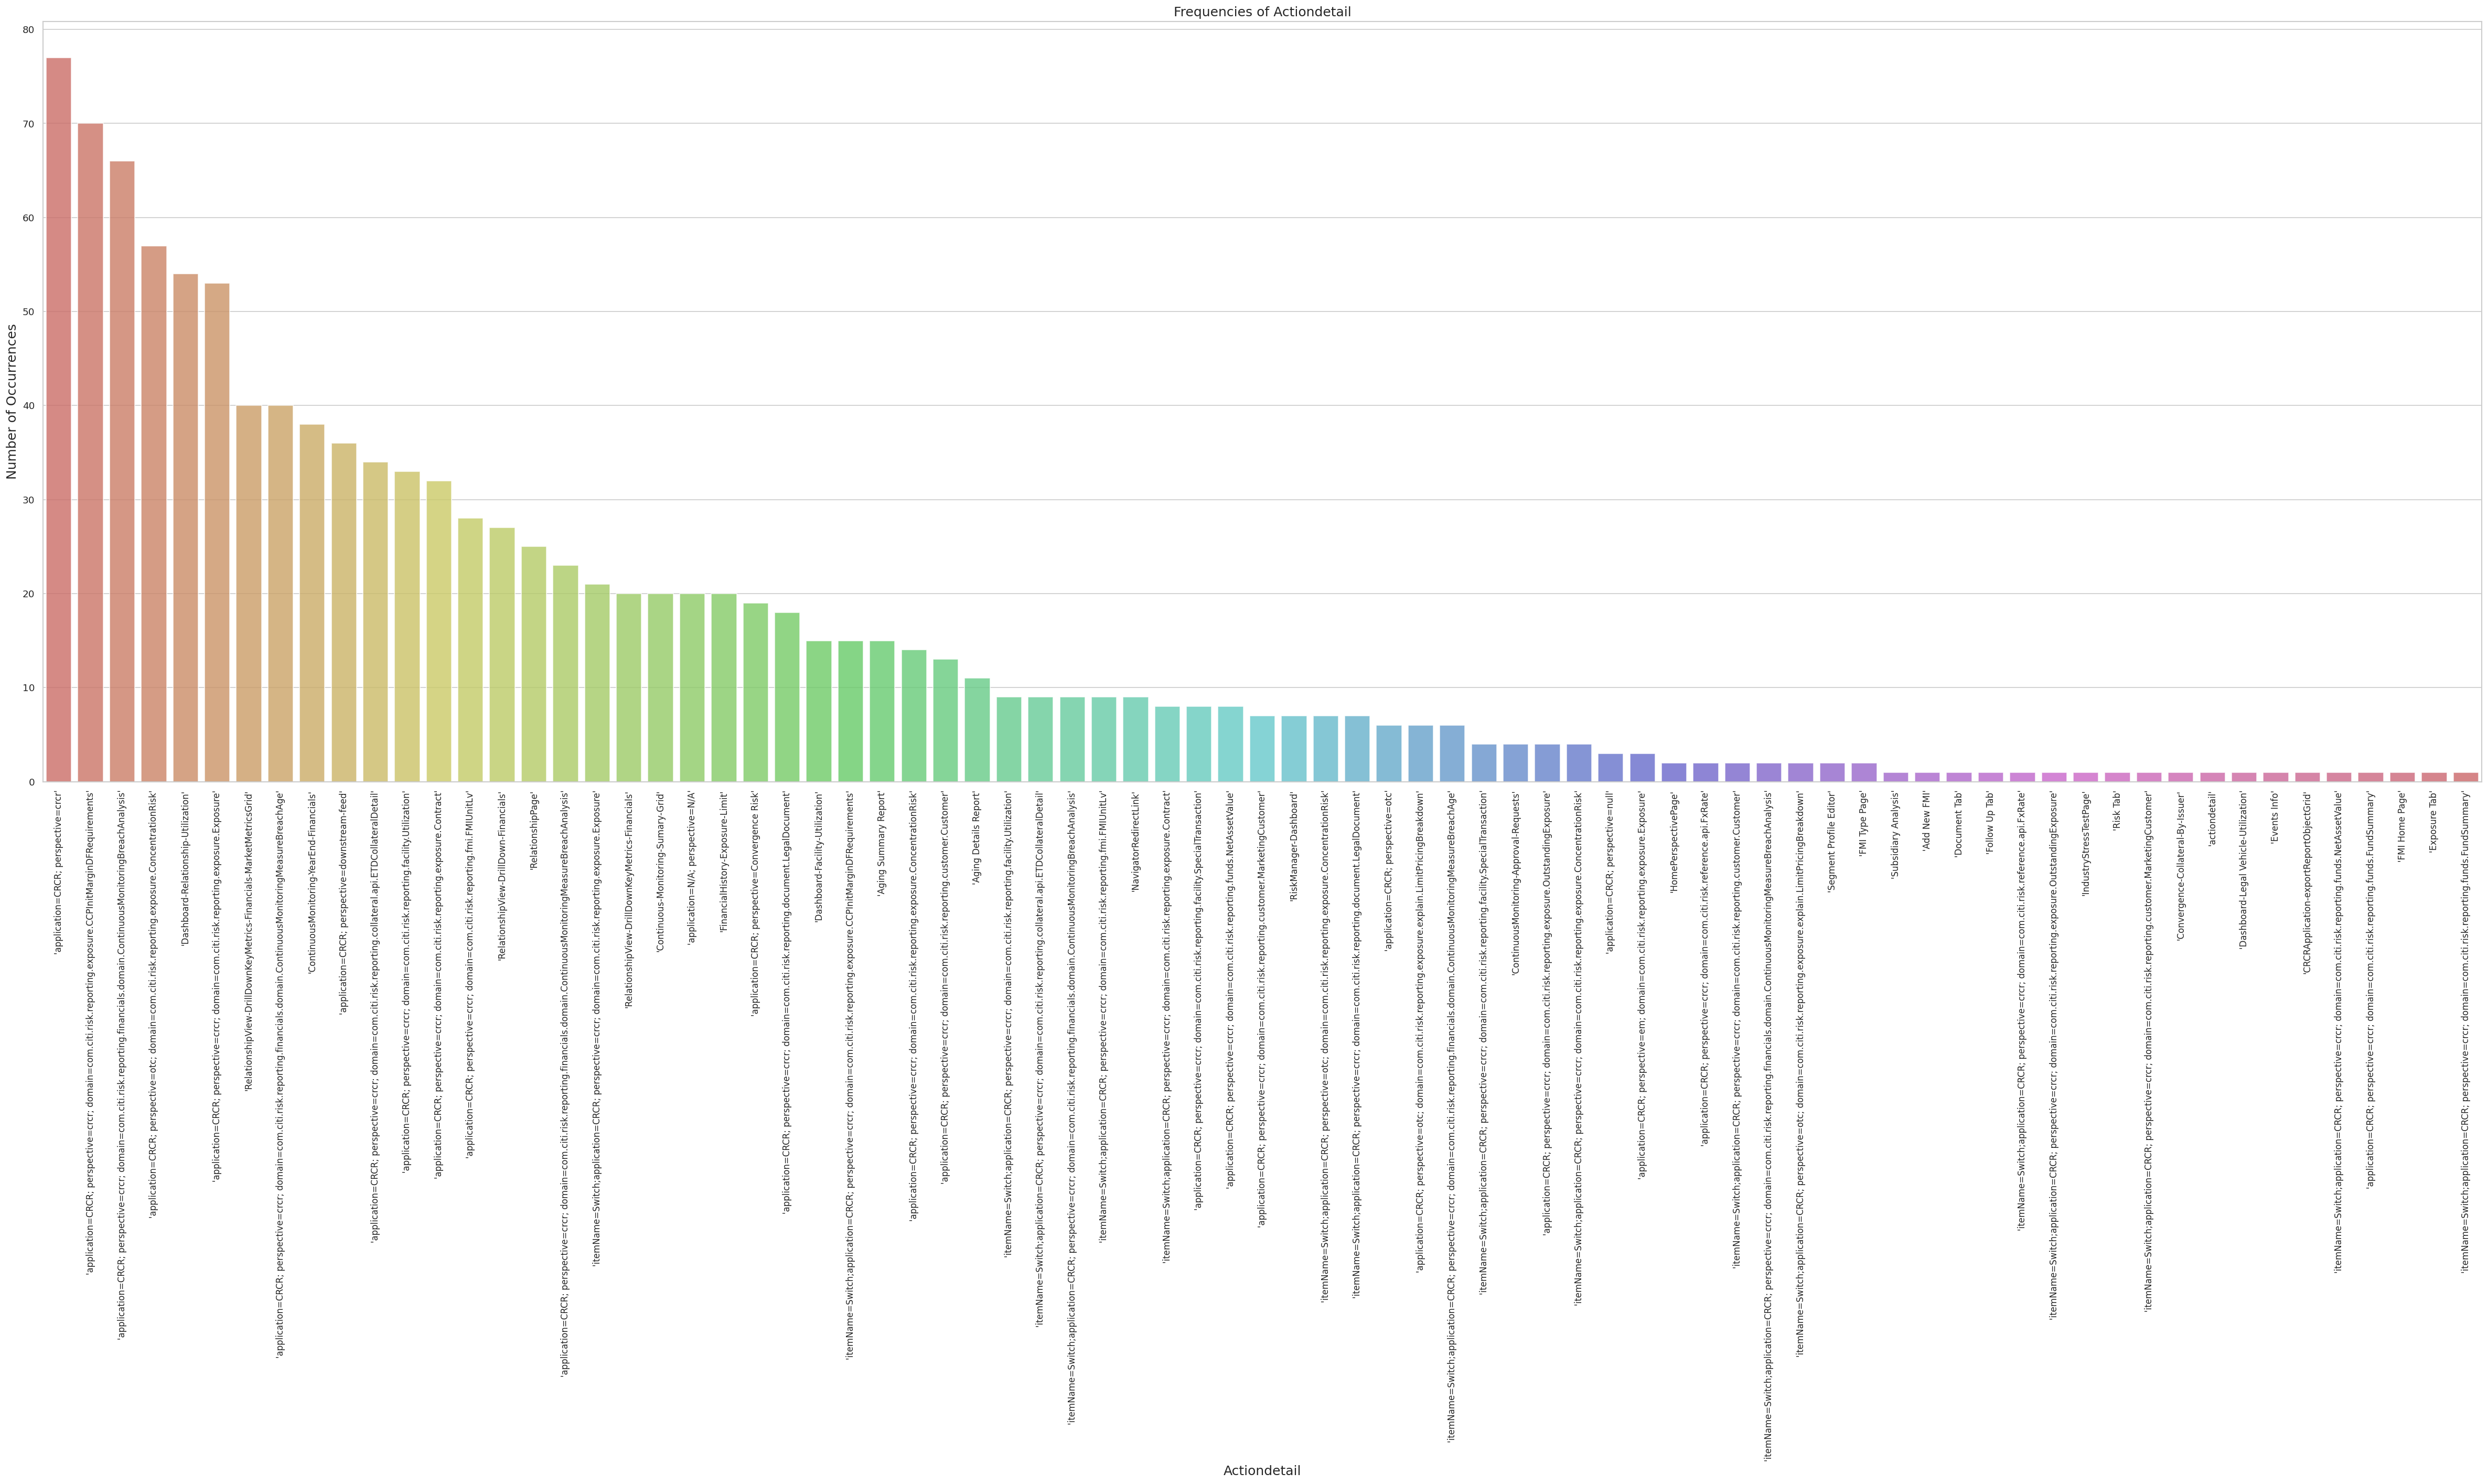

In [130]:
# frequency plots of each category in each column
for i in range(len(display_columns)):
  name = display_columns[i].replace("'","").capitalize()
  plt.figure(figsize=(50,16))
  ax = sns.countplot(x = f"{display_columns[i]}",
                data = df_raw,
                order = df_raw[f"{display_columns[i]}"].value_counts().index,
                alpha=0.8,
                palette='hls')
  ax.set_xlabel(f"{name}",fontdict=dict(fontsize=15))
  ax.set_ylabel('Number of Occurrences',fontdict=dict(fontsize=15))
  ax.set_title(f'Frequencies of {name}',fontdict=dict(fontsize=15))
  ax.set_xticklabels(df_raw[f"{display_columns[i]}"].value_counts().index, rotation='vertical', fontsize=10)
  plt.show()

# Visualization of features by country

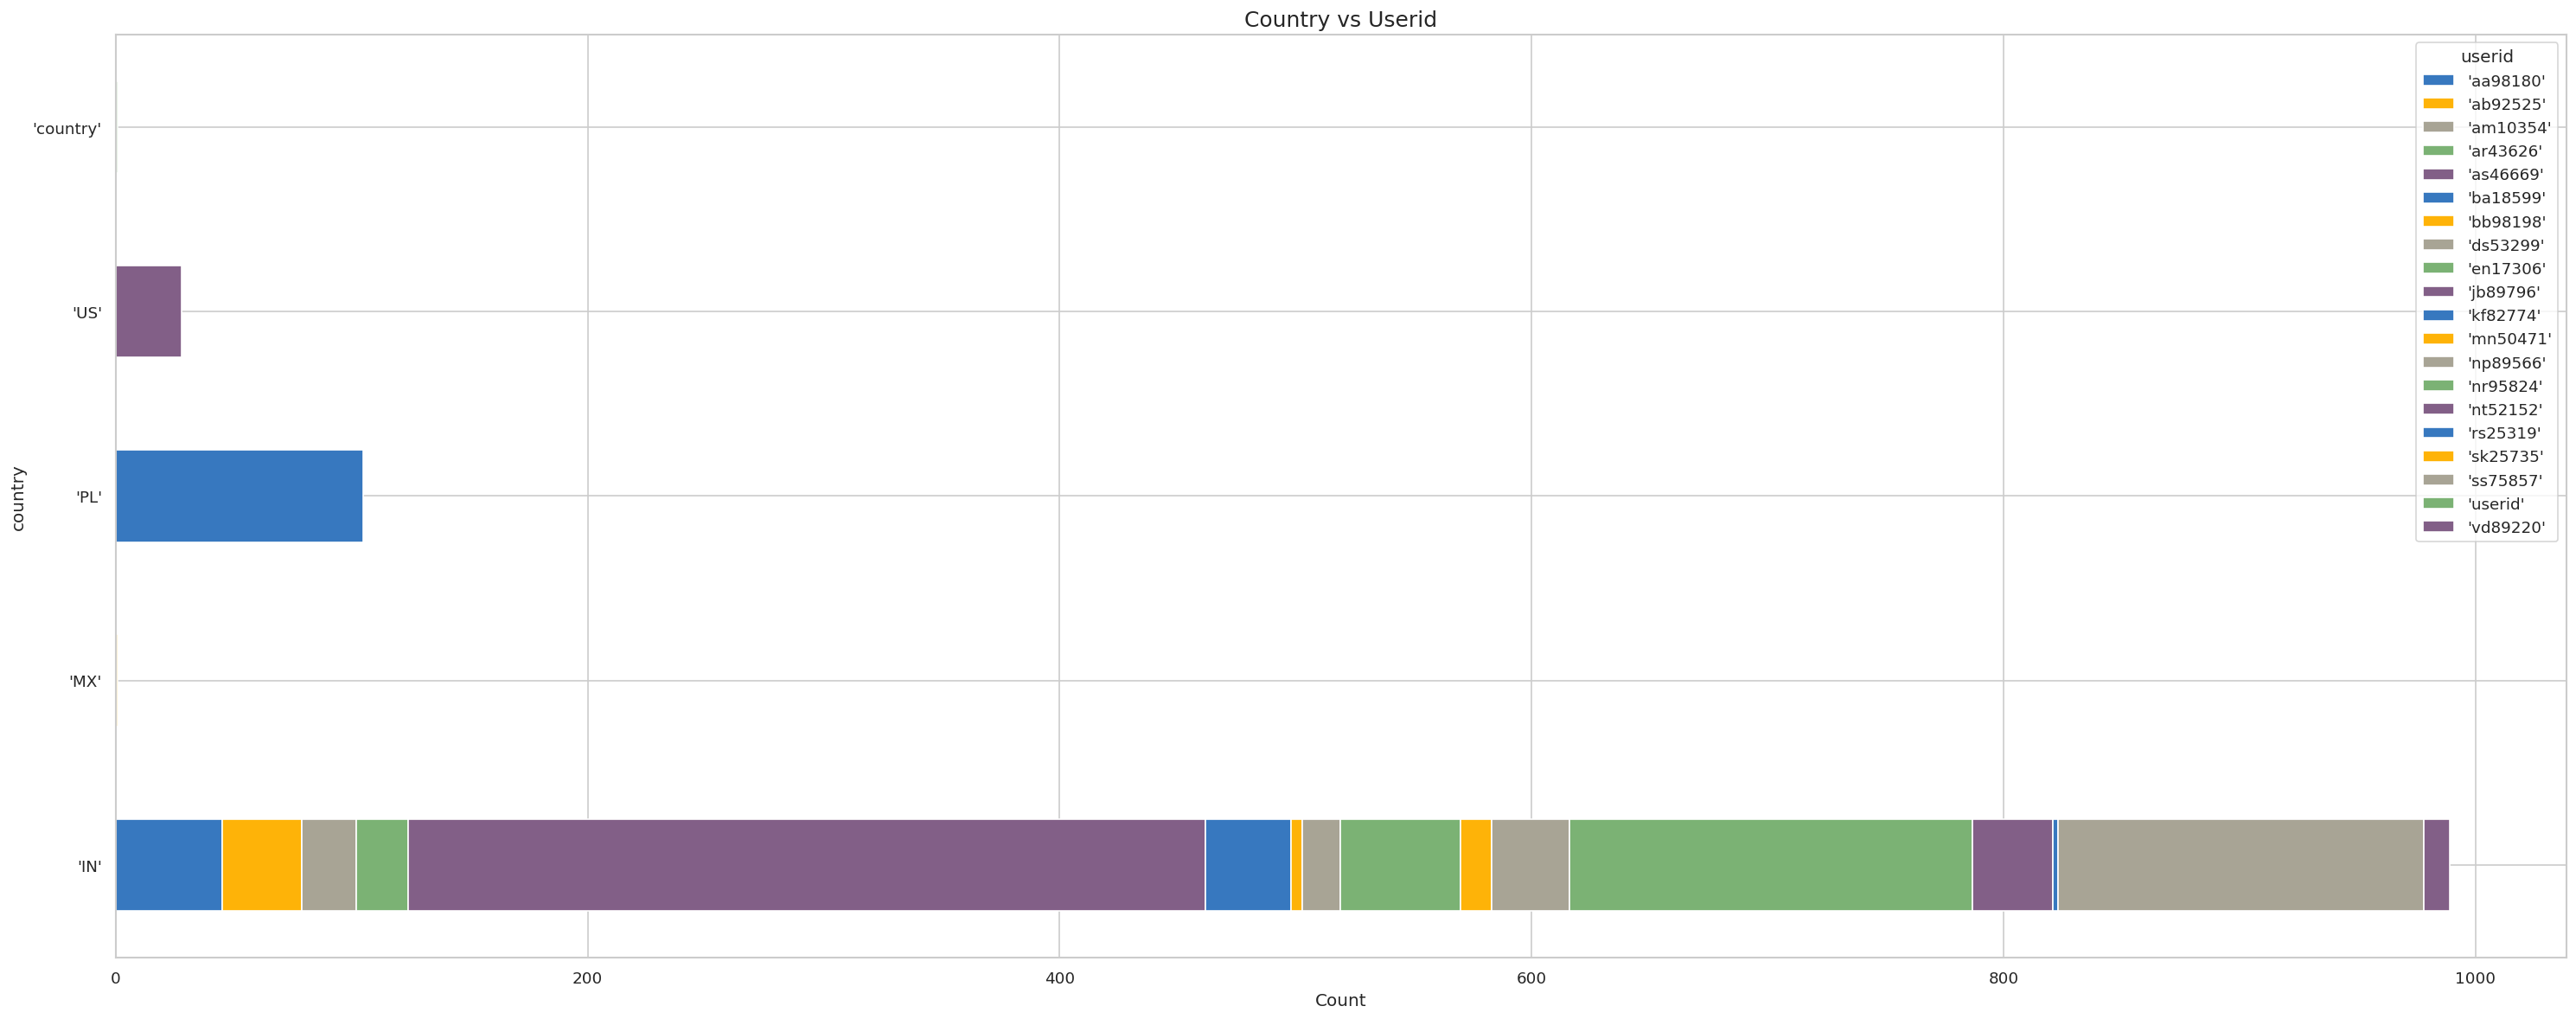

<Figure size 720x600 with 0 Axes>

In [131]:
pd.crosstab(df_raw["country"],df_raw["userid"]).plot(kind='barh',stacked=True,figsize=(25,10))
plt.title('Country vs Userid',fontsize=15)
plt.xlabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.clf()

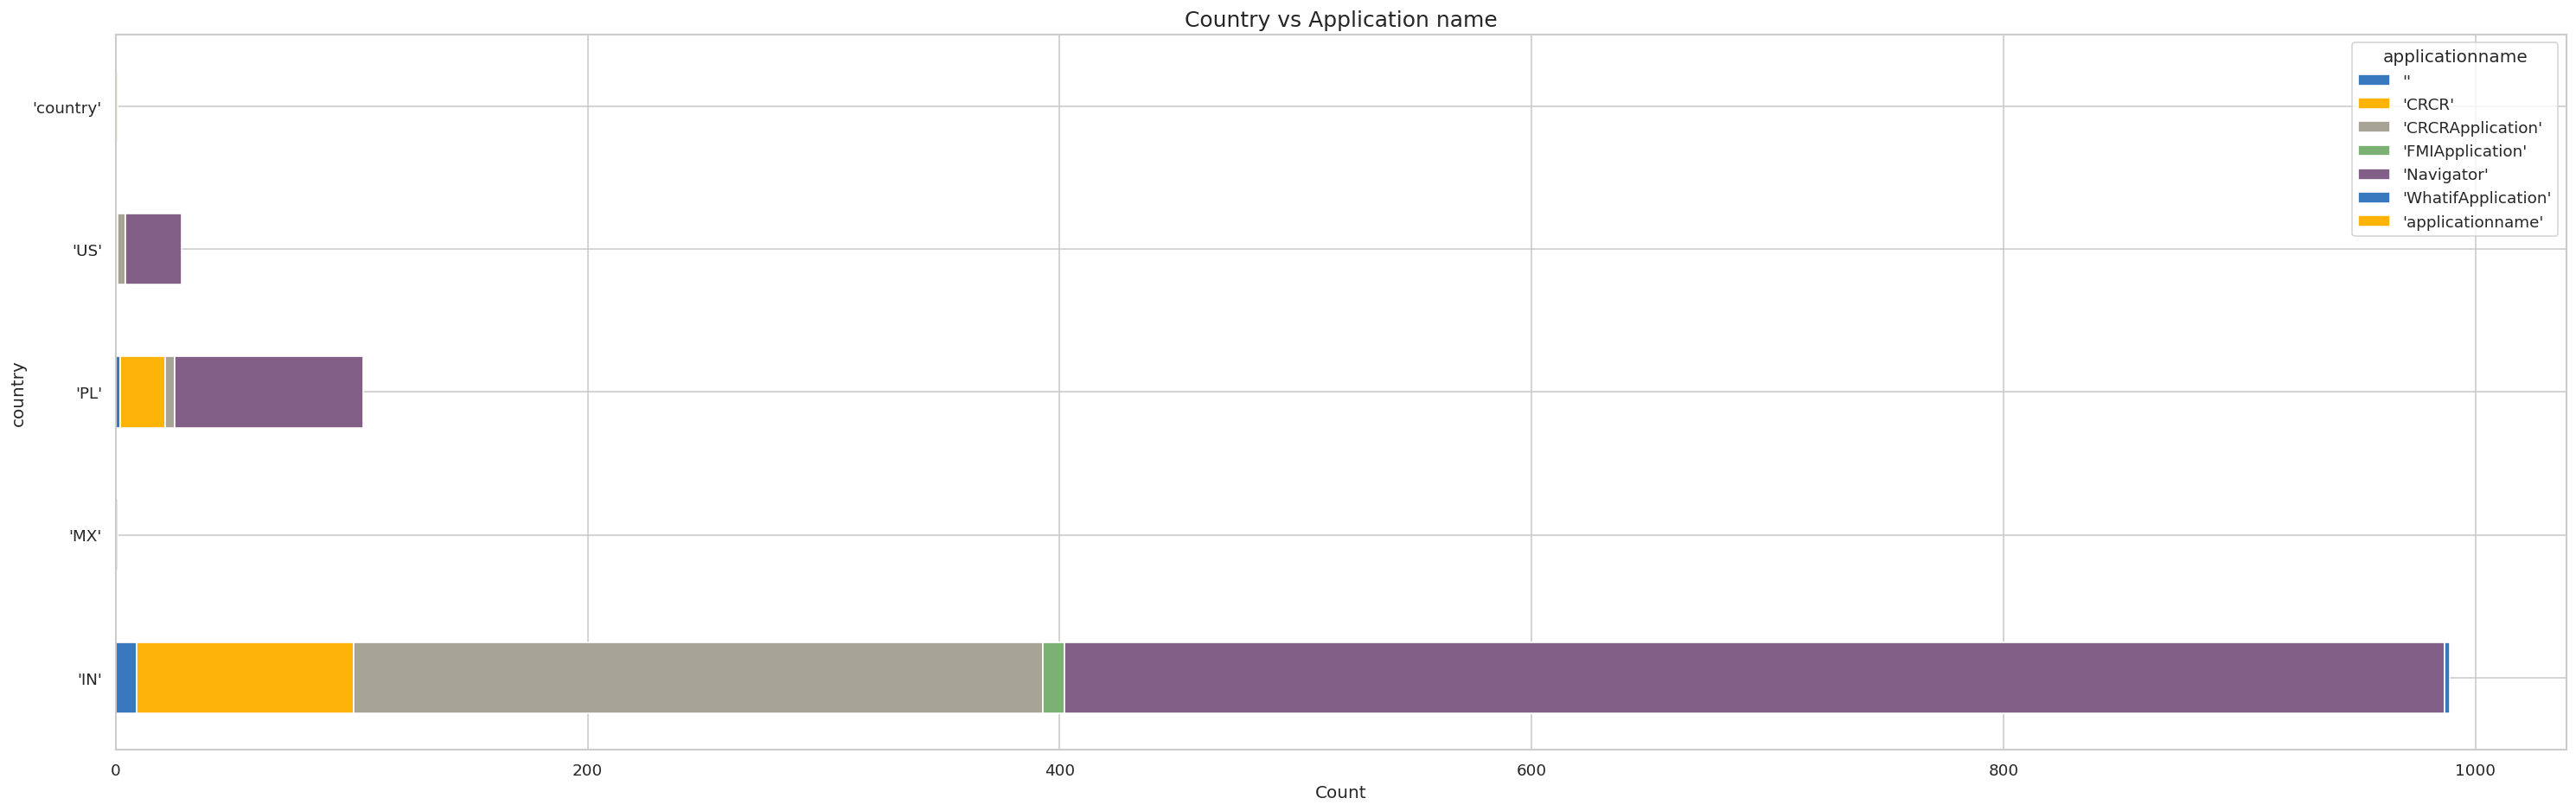

<Figure size 720x600 with 0 Axes>

In [132]:
pd.crosstab(df_raw["country"],df_raw["applicationname"]).plot(kind='barh',figsize=(25,8),stacked=True)
plt.title('Country vs Application name',fontsize=15)
plt.xlabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.clf()

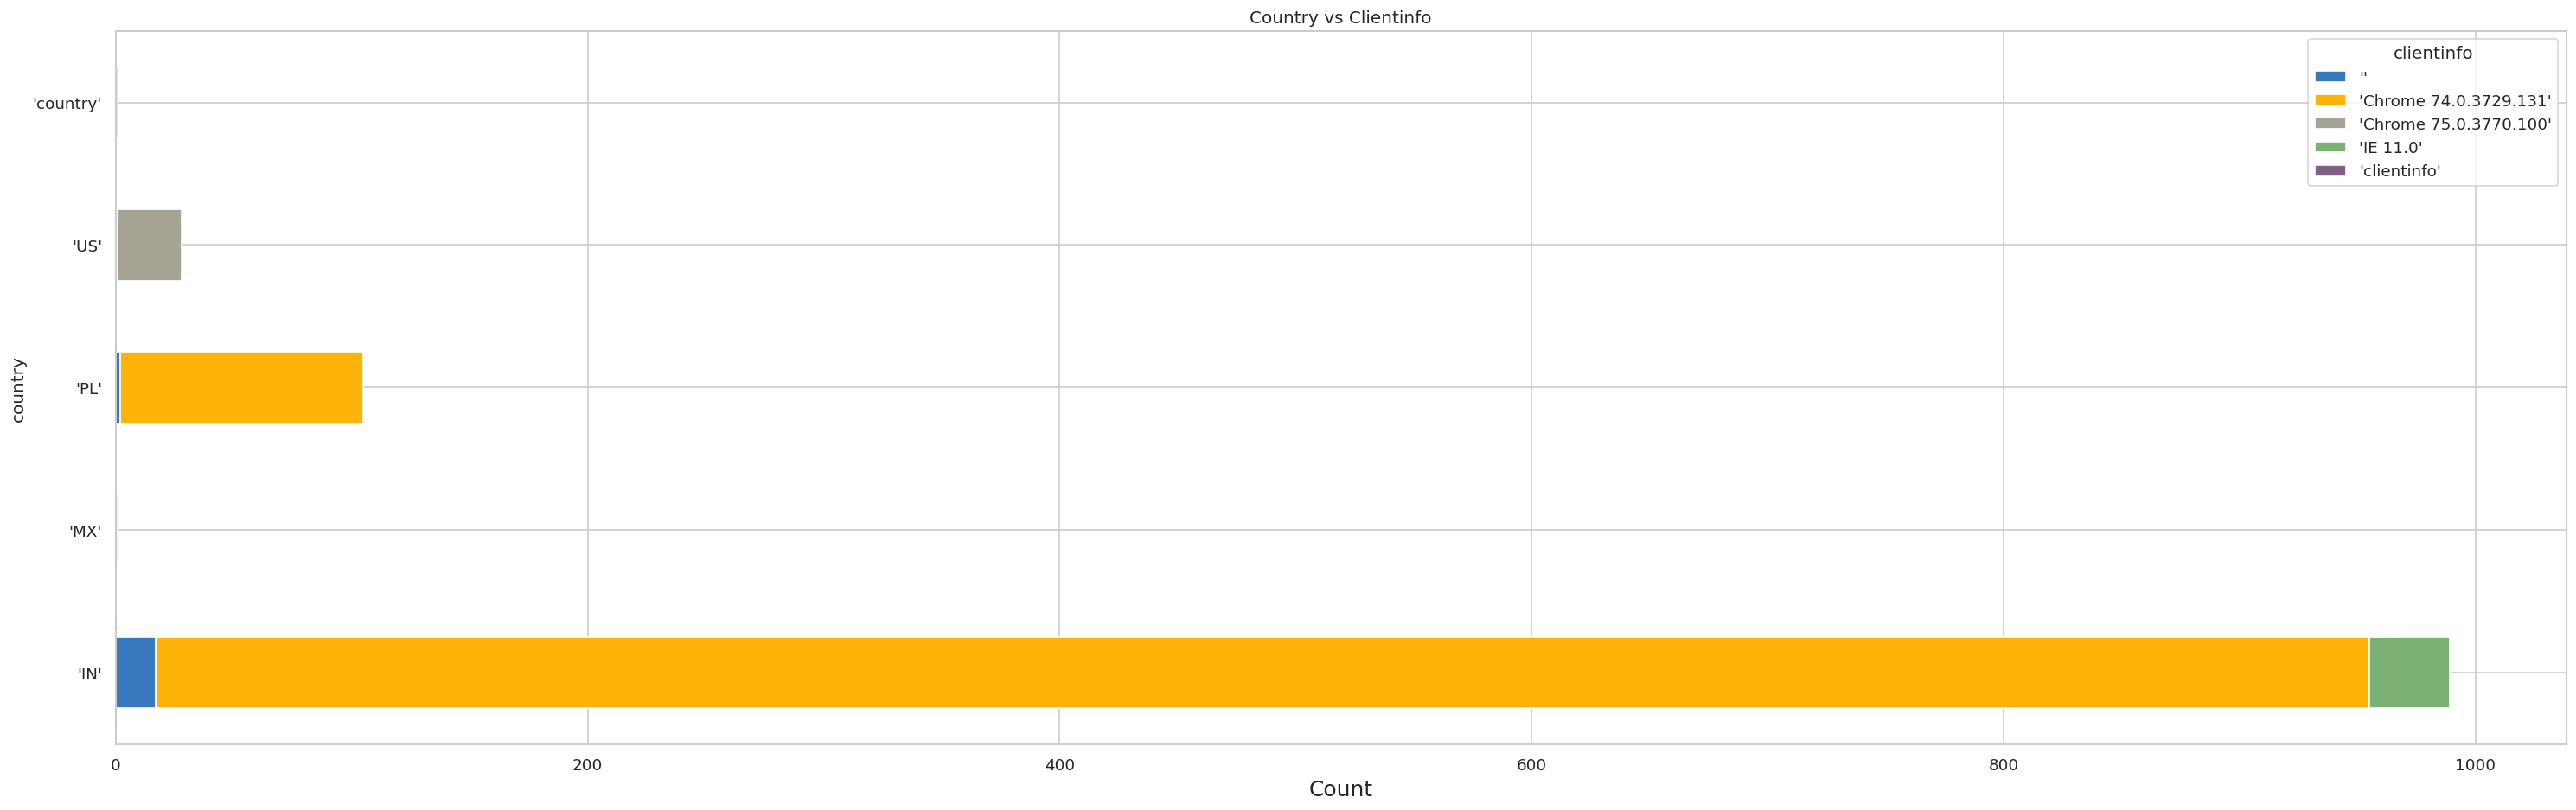

<Figure size 720x600 with 0 Axes>

In [133]:
pd.crosstab(df_raw["country"],df_raw["clientinfo"]).plot(kind='barh',figsize=(25,8),stacked=True)
plt.title('Country vs Clientinfo')
plt.xlabel('Count',fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.clf()

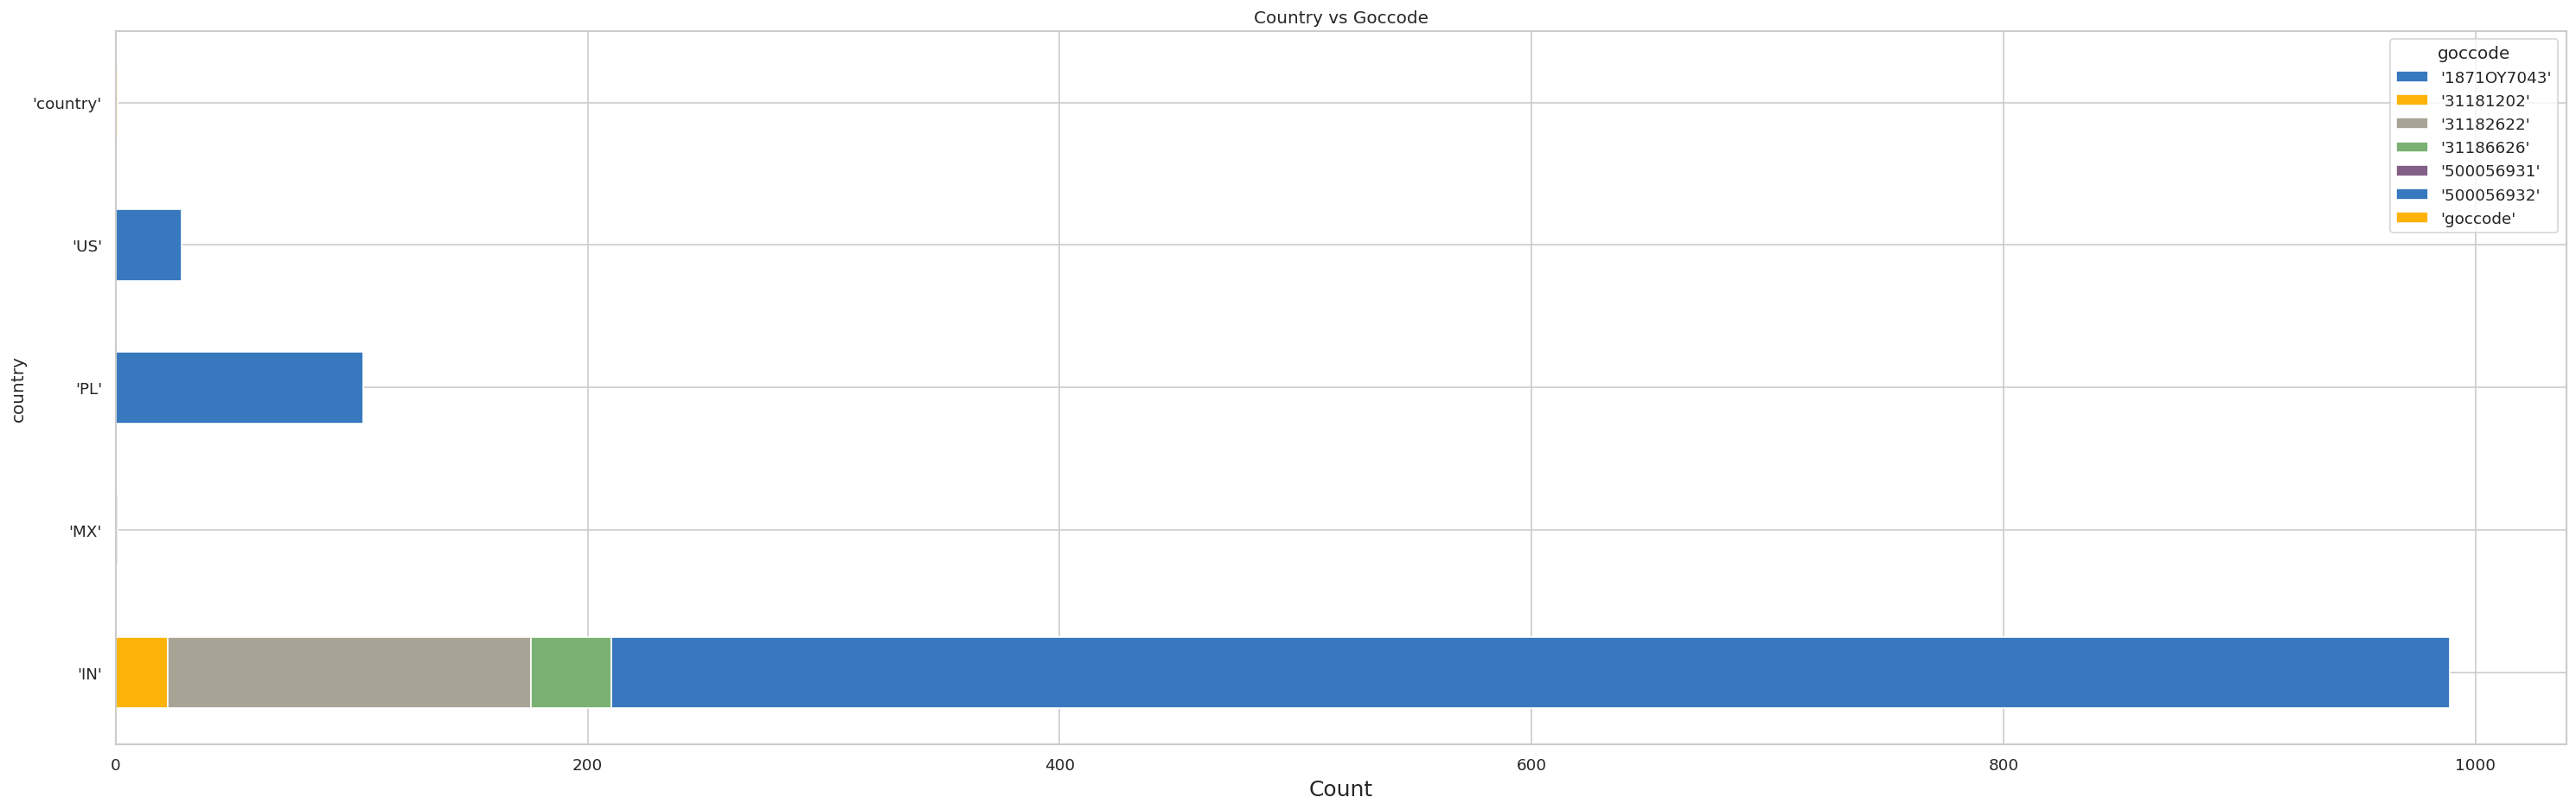

<Figure size 720x600 with 0 Axes>

In [134]:
pd.crosstab(df_raw["country"],df_raw["goccode"]).plot(kind='barh',figsize=(25,8),stacked=True)
plt.title('Country vs Goccode')
plt.xlabel('Count',fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.clf()

## Response Time

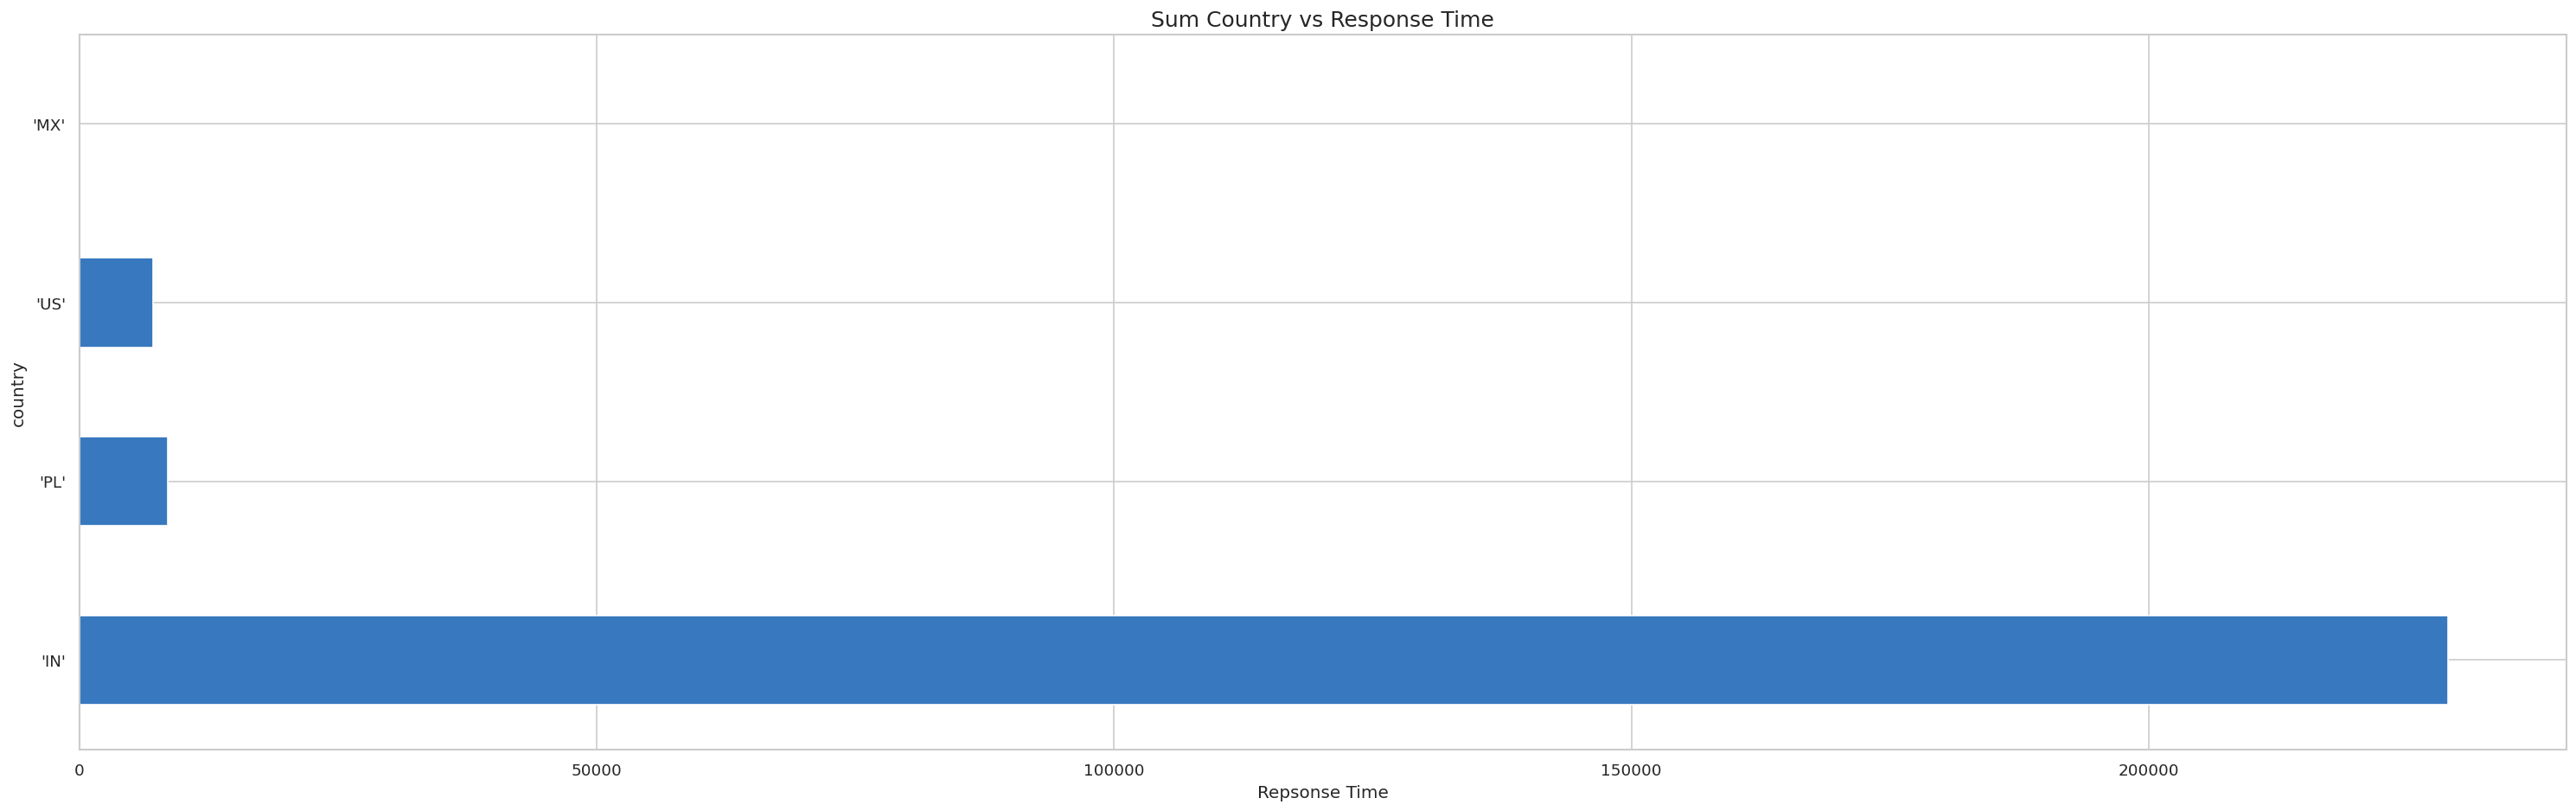

<Figure size 720x600 with 0 Axes>

In [152]:
# country vs response time - sum
df_raw.groupby(["country"])["responsetime"].sum().sort_values(ascending=False).plot(kind='barh',figsize=(25,8))
plt.xlabel('Repsonse Time')
plt.title('Sum Country vs Response Time',fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.clf()

Text(0.5, 1.0, 'Reponse Time of each client in different countries')

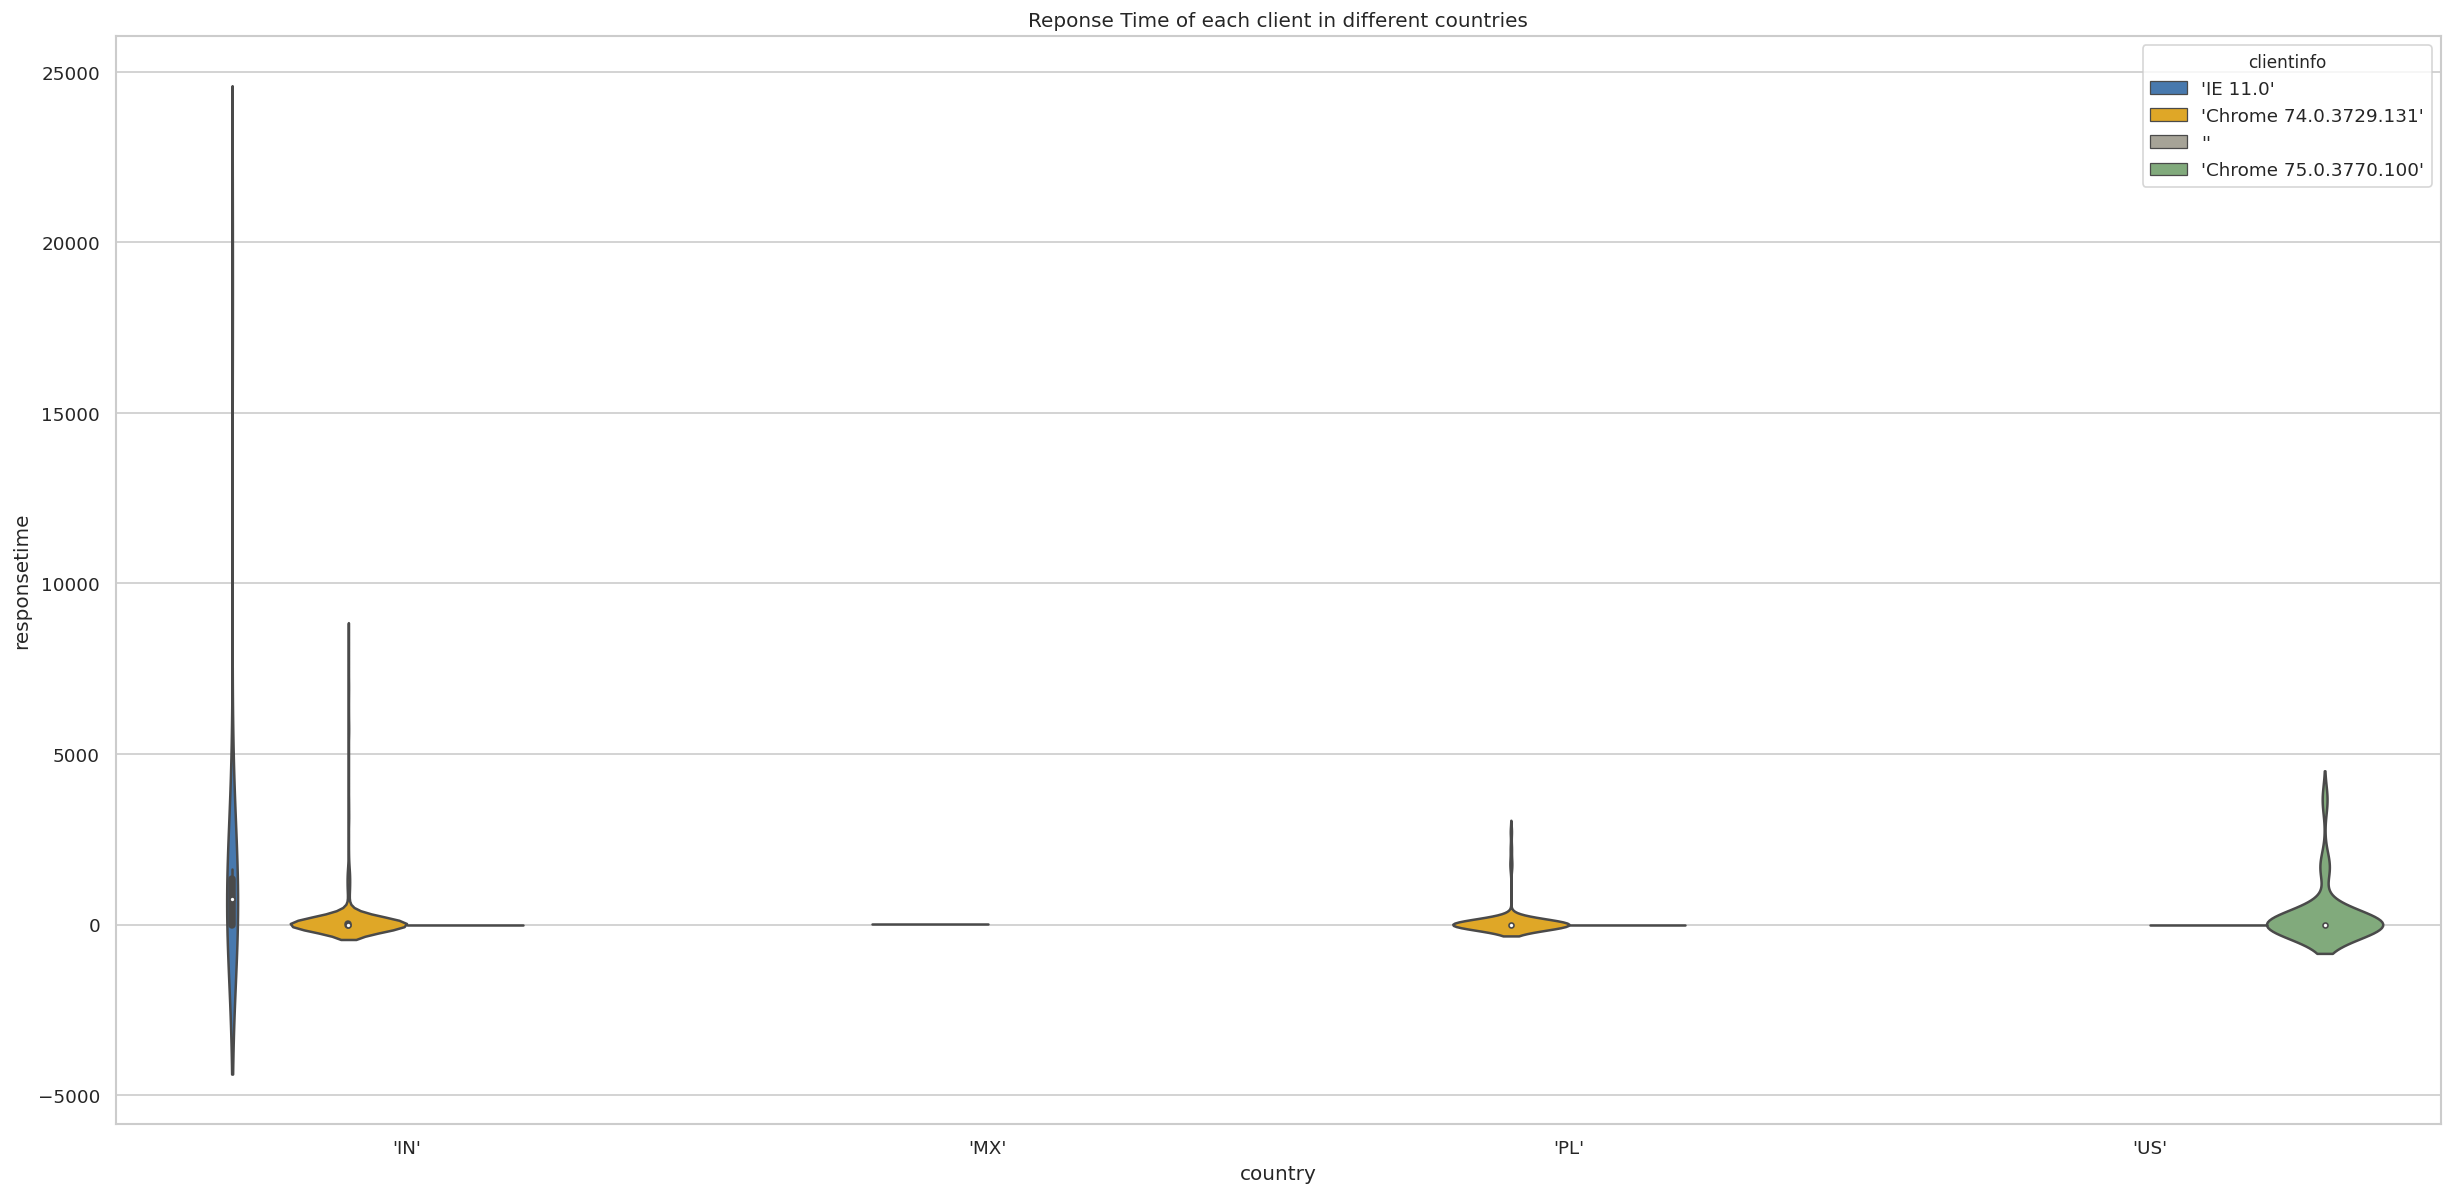

In [178]:
plt.figure(figsize=(25,12))
sns.violinplot(data = df_raw, x='country', y='responsetime', hue='clientinfo')
plt.title("Reponse Time of each client in different countries")

Text(0.5, 1.0, 'Outlier Detection')

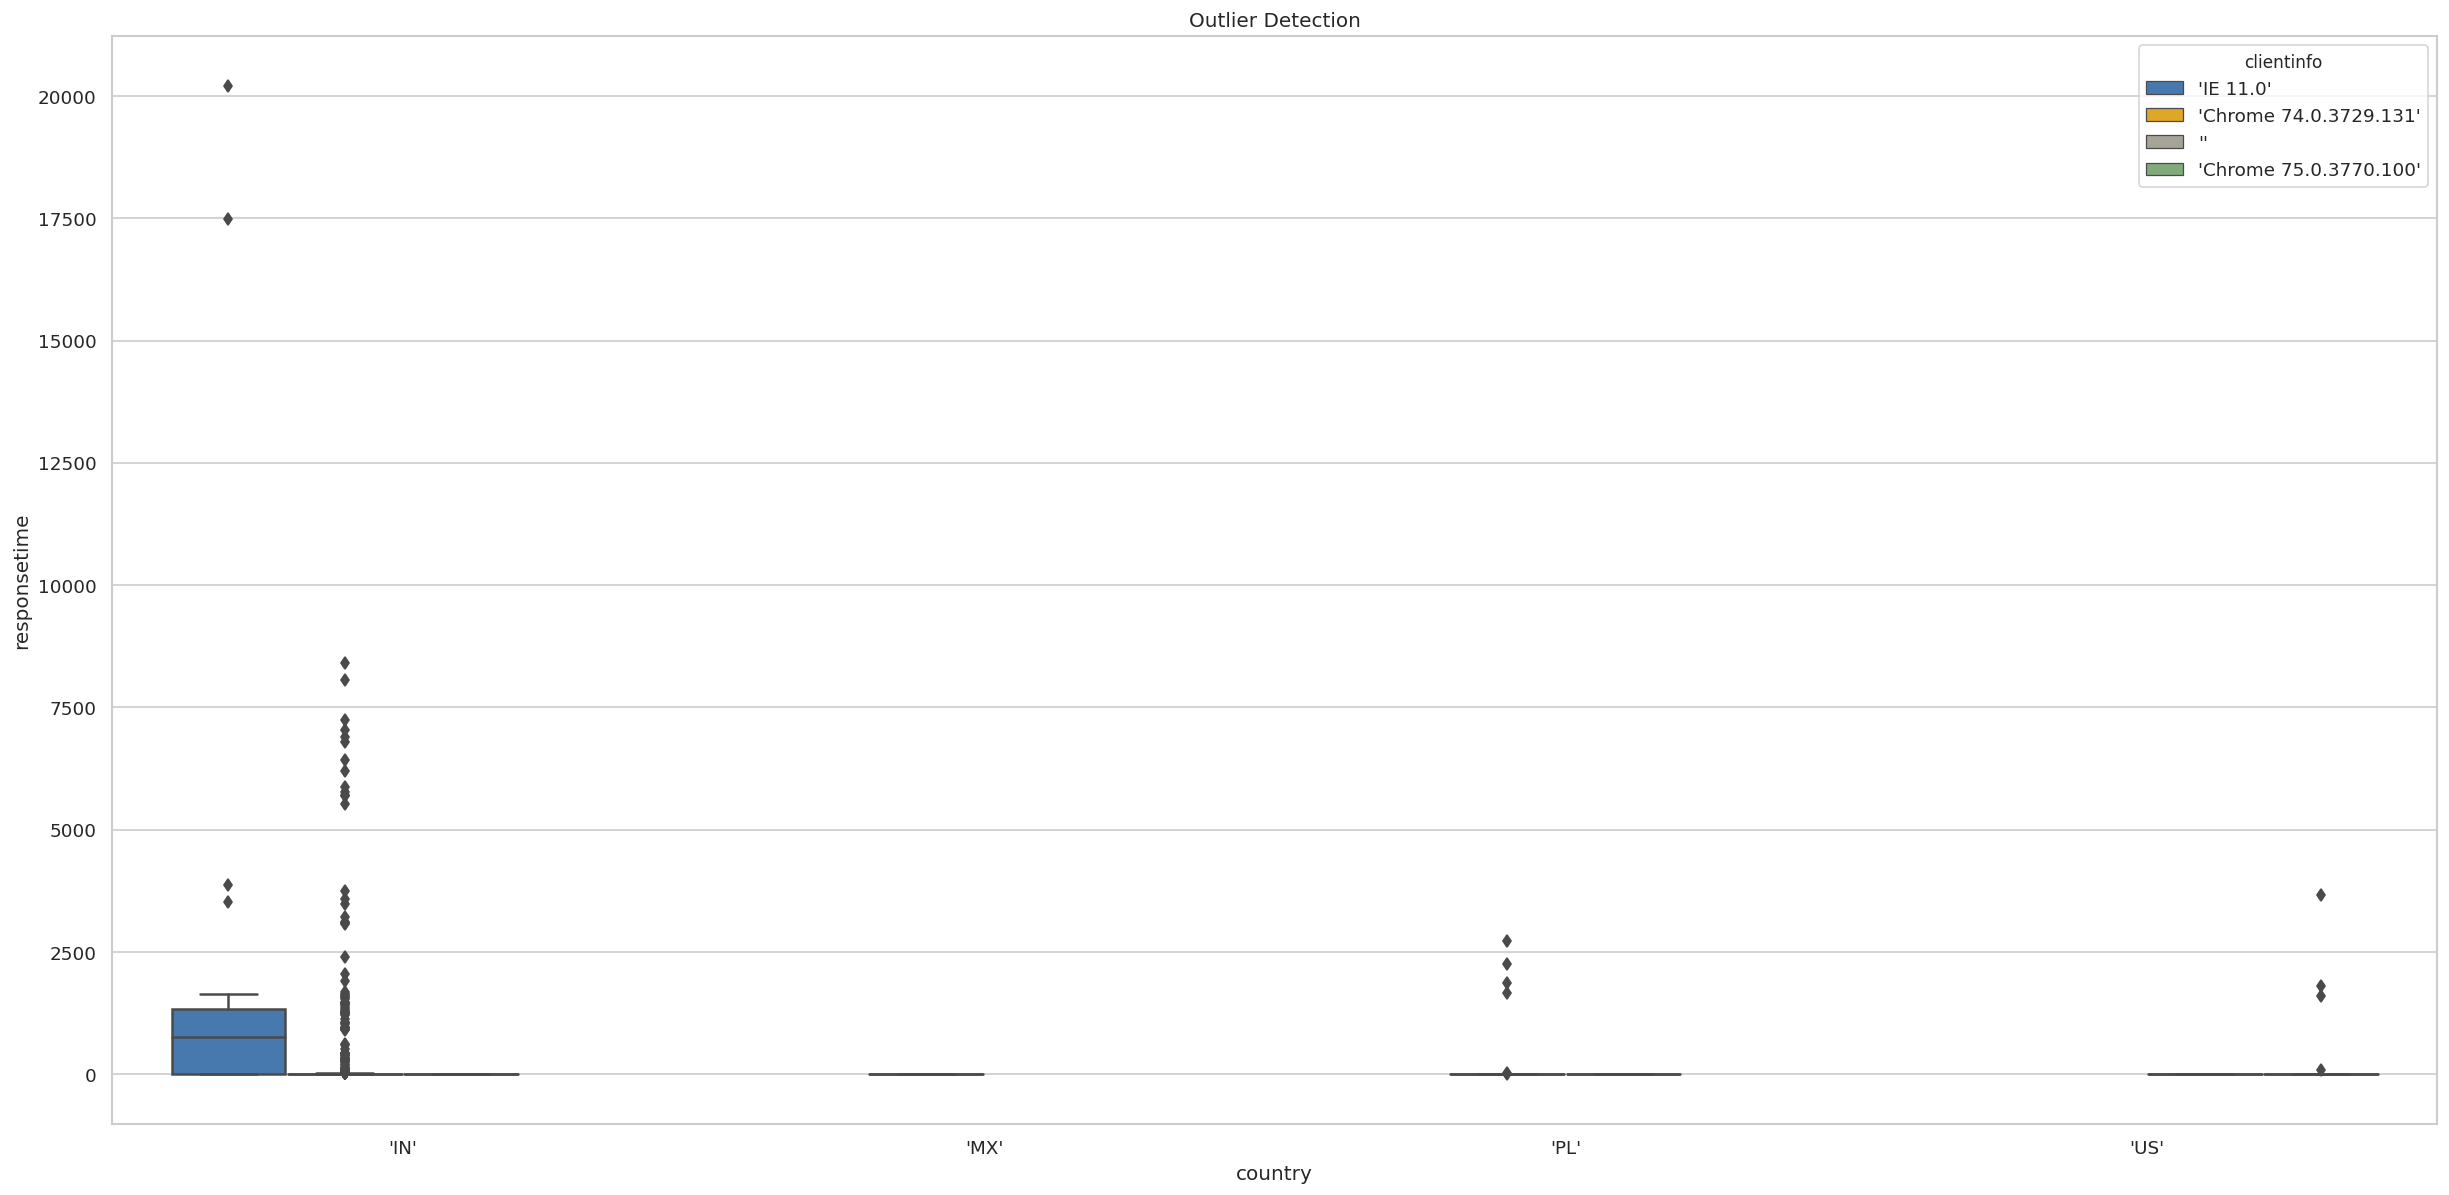

In [179]:
plt.figure(figsize=(25,12))
sns.boxplot(data = df_raw, x='country', y='responsetime', hue='clientinfo')
plt.title("Outlier Detection")

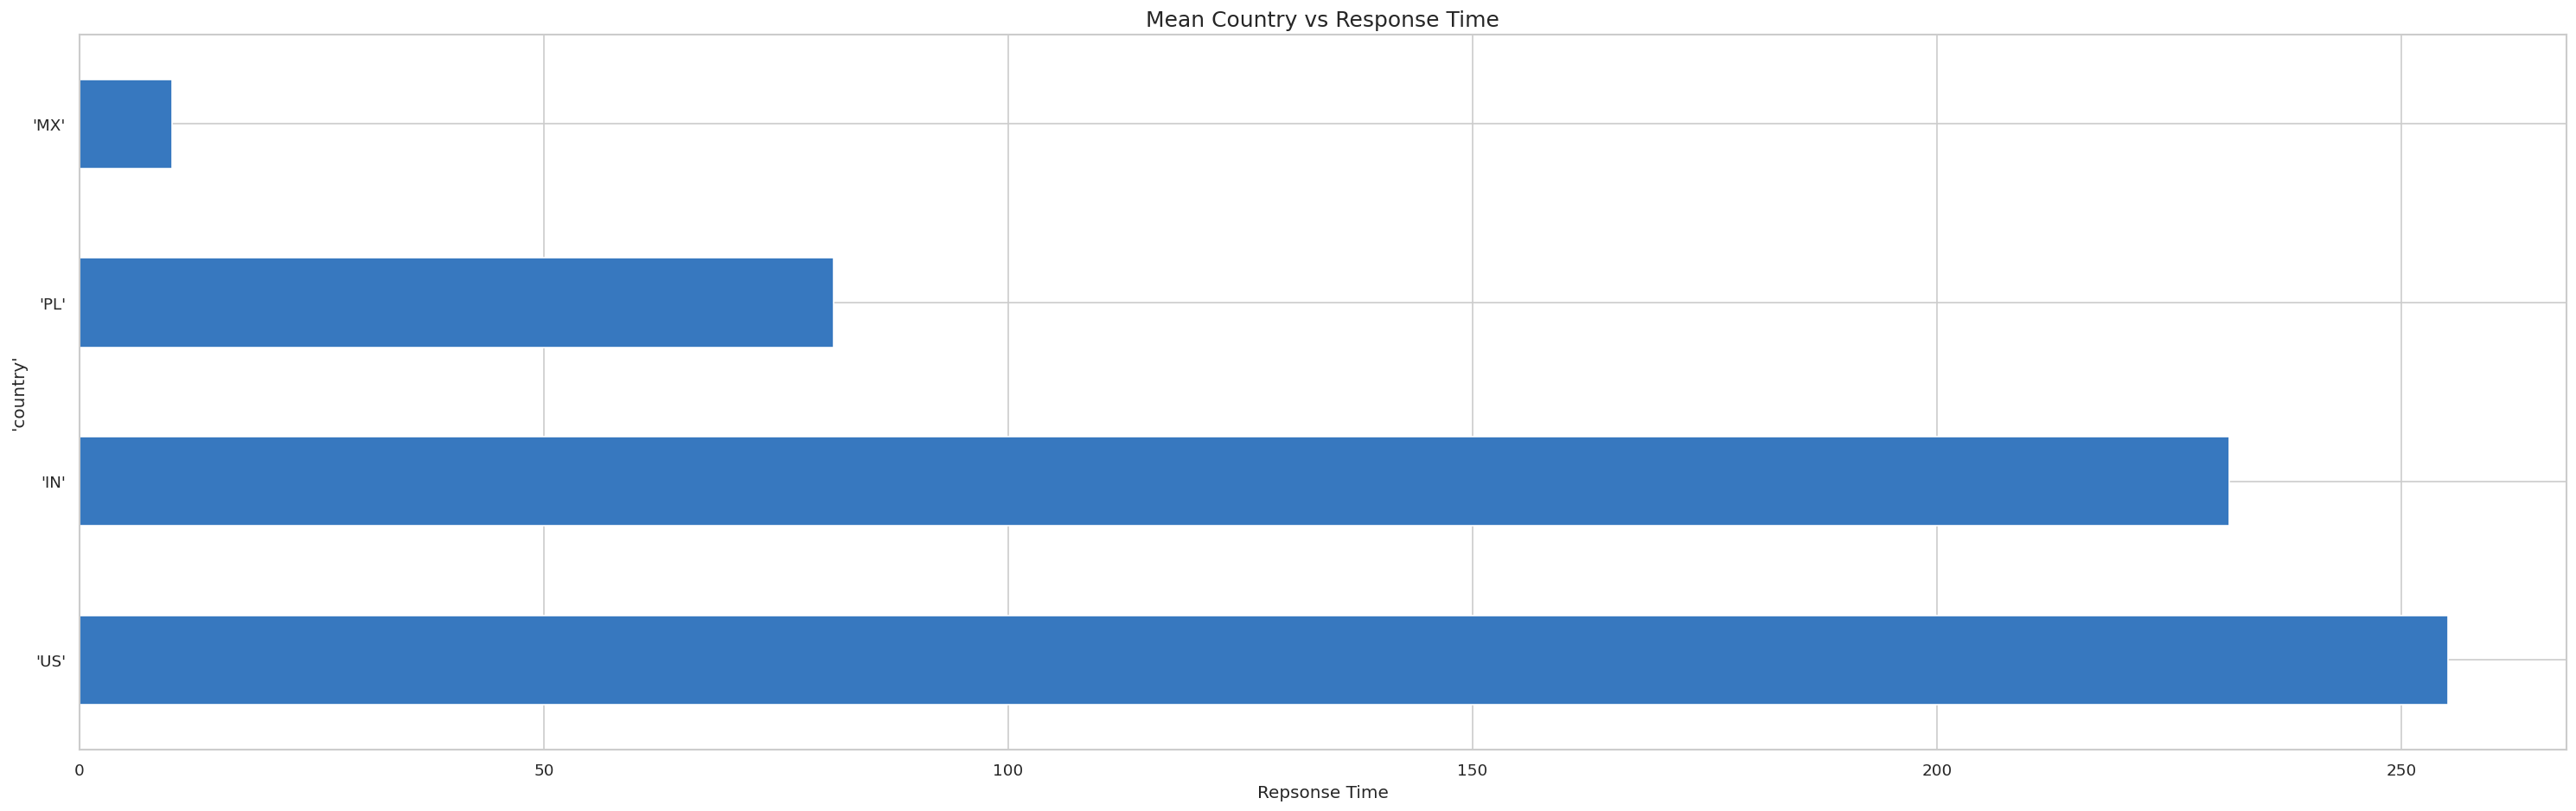

<Figure size 720x600 with 0 Axes>

In [244]:
df_raw.groupby(["country"])["responsetime"].mean().sort_values(ascending=False).plot(kind='barh',figsize=(25,8))
plt.xlabel('Repsonse Time')
plt.title('Mean Country vs Response Time',fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.clf()

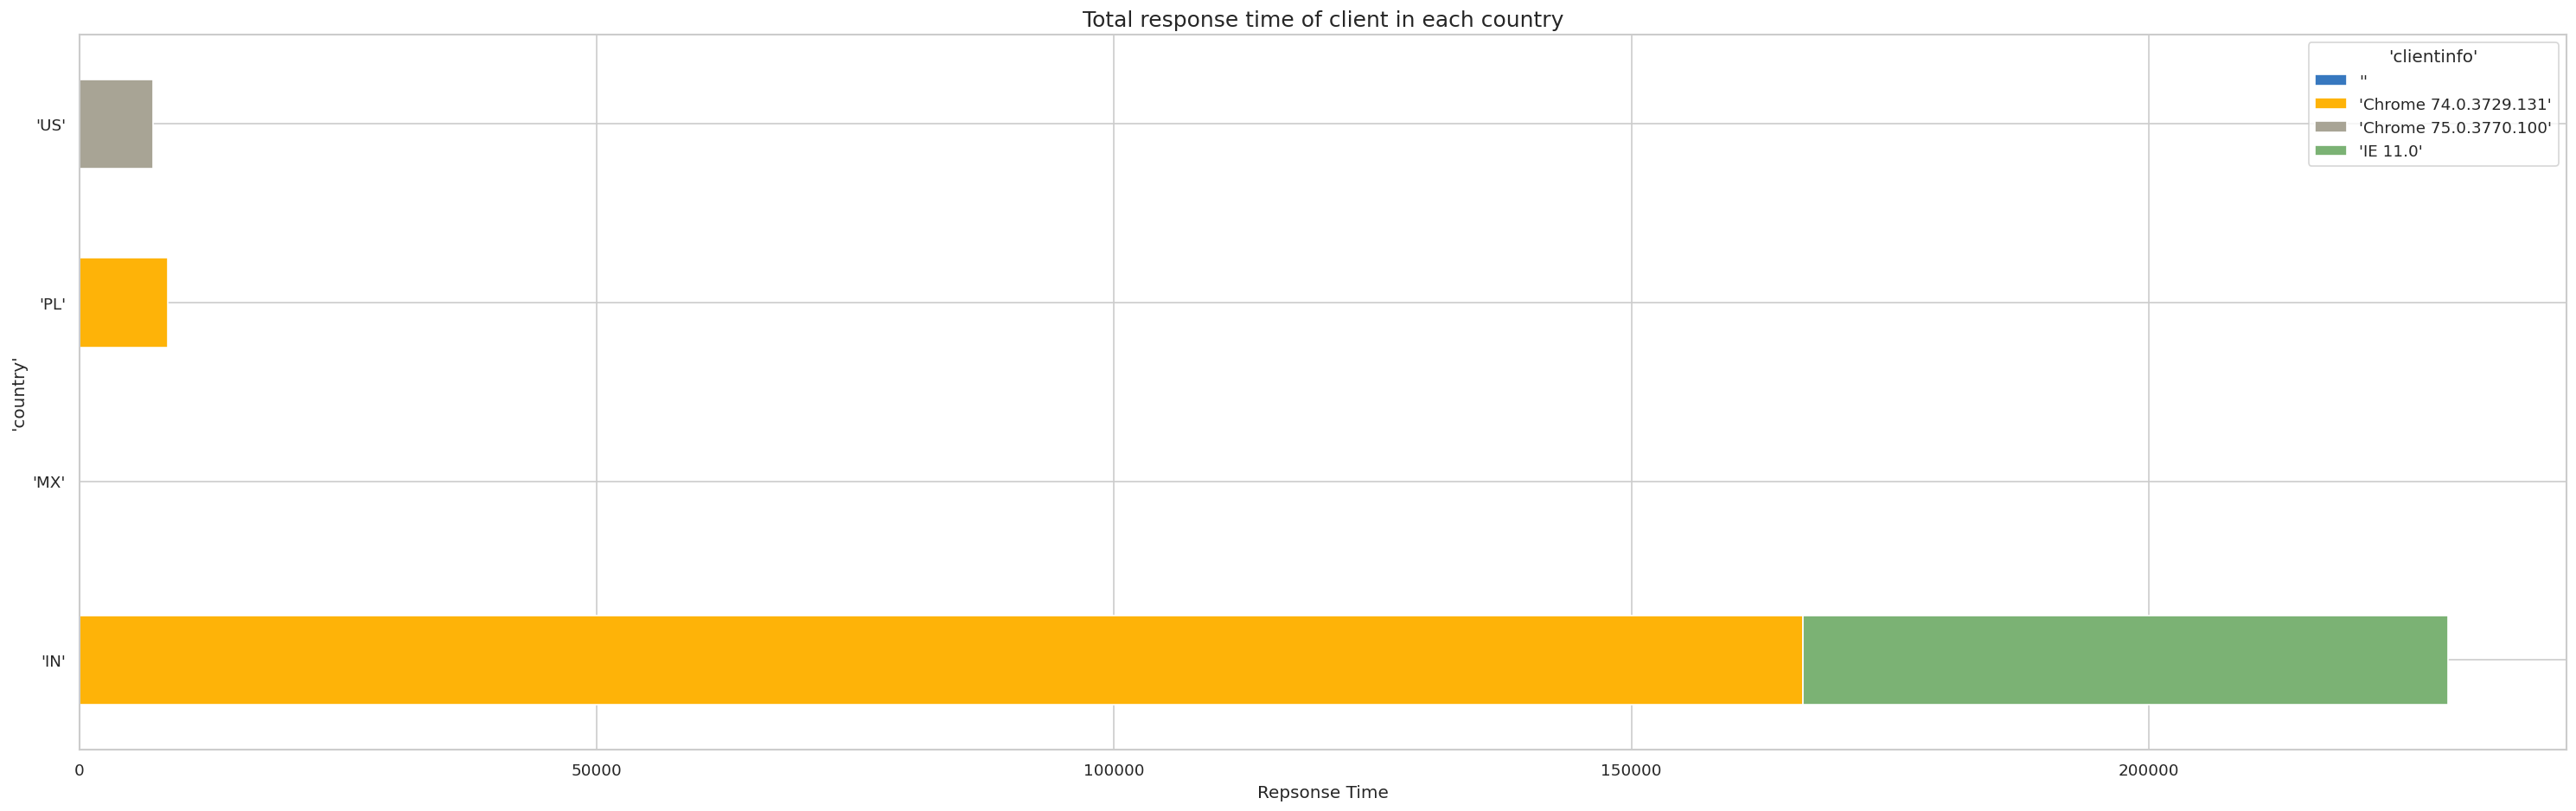

<Figure size 720x600 with 0 Axes>

In [245]:
# total response time of client in each country
df_raw.groupby(["'country'","'clientinfo'"])["'responsetime'"].sum().unstack().fillna(0).plot(kind='barh',stacked=True,figsize=(25,8))
plt.xlabel('Repsonse Time')
plt.title('Total response time of client in each country',fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.clf()

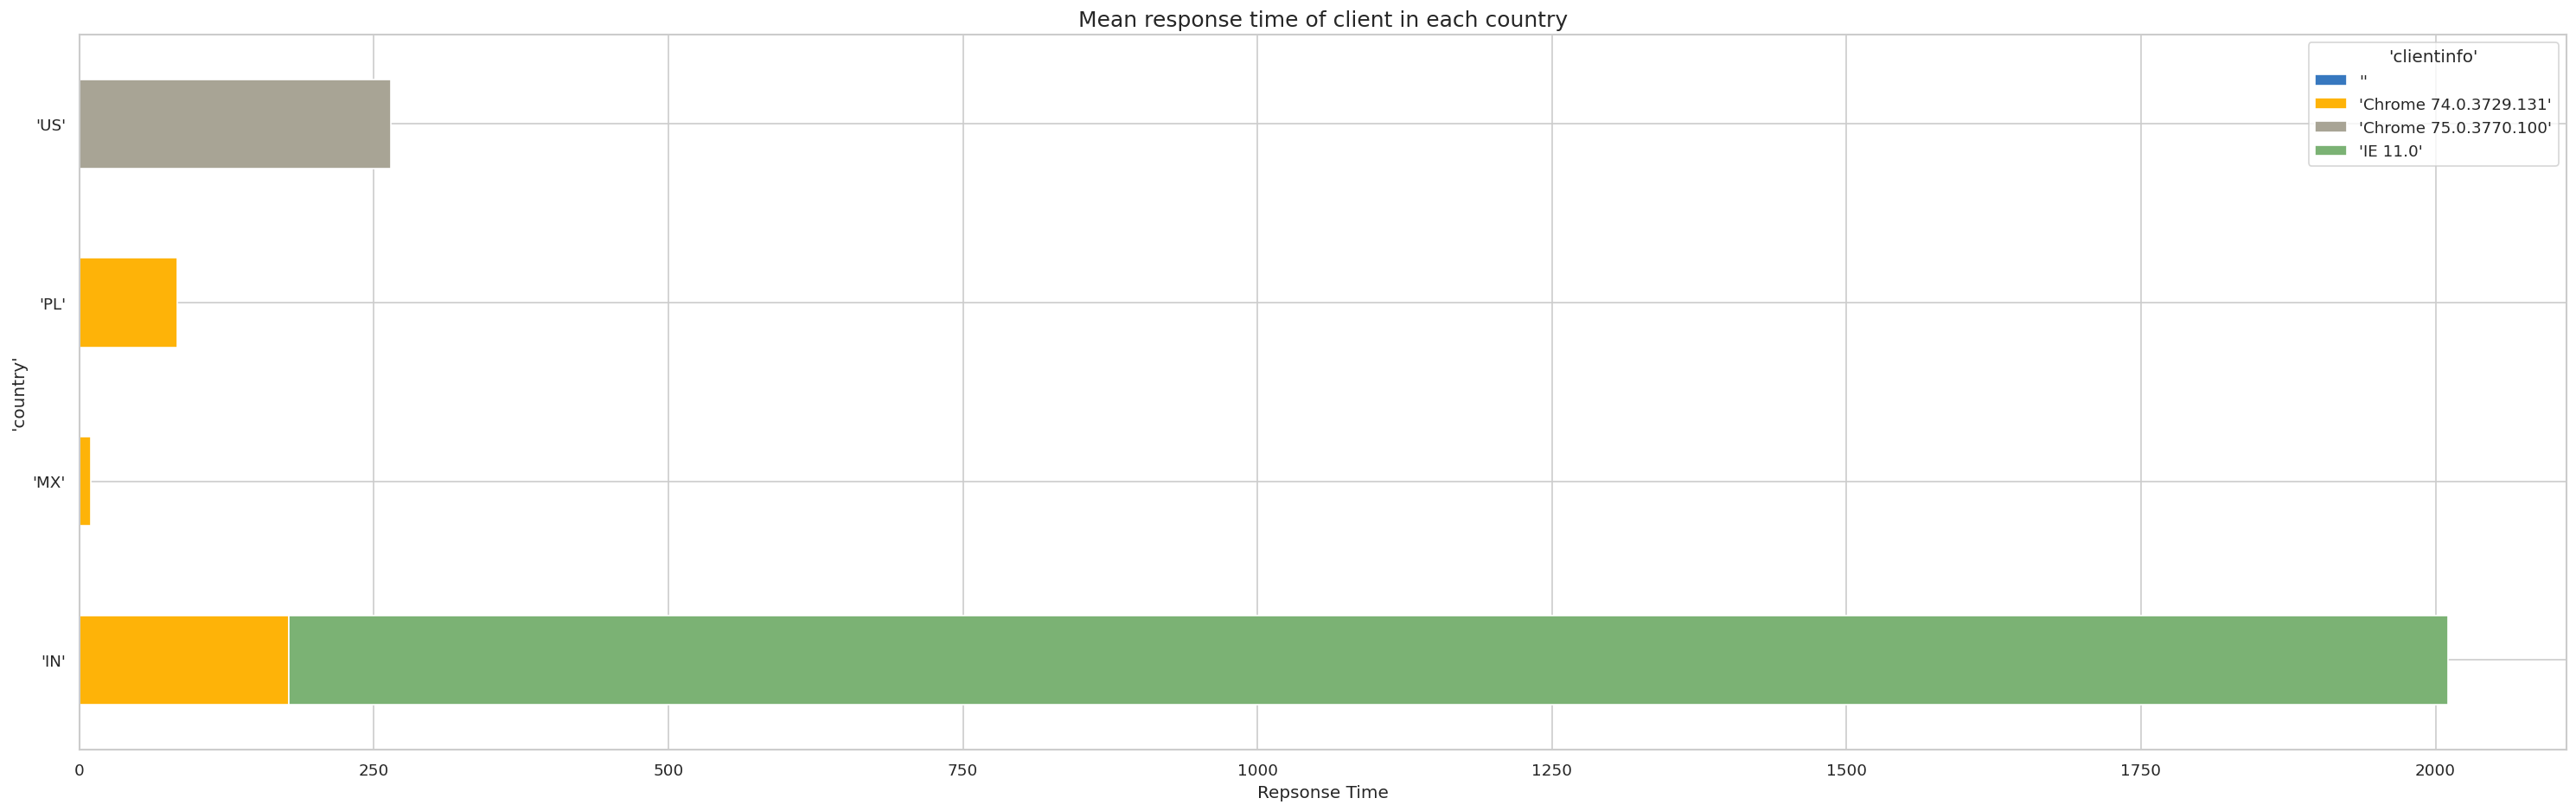

<Figure size 720x600 with 0 Axes>

In [246]:
# average reponse time of each application in each country
df_raw.groupby(["'country'","'clientinfo'"])["'responsetime'"].mean().unstack().fillna(0).plot(kind='barh',stacked=True,figsize=(25,8))
plt.xlabel('Repsonse Time')
plt.title('Mean response time of client in each country',fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.clf()

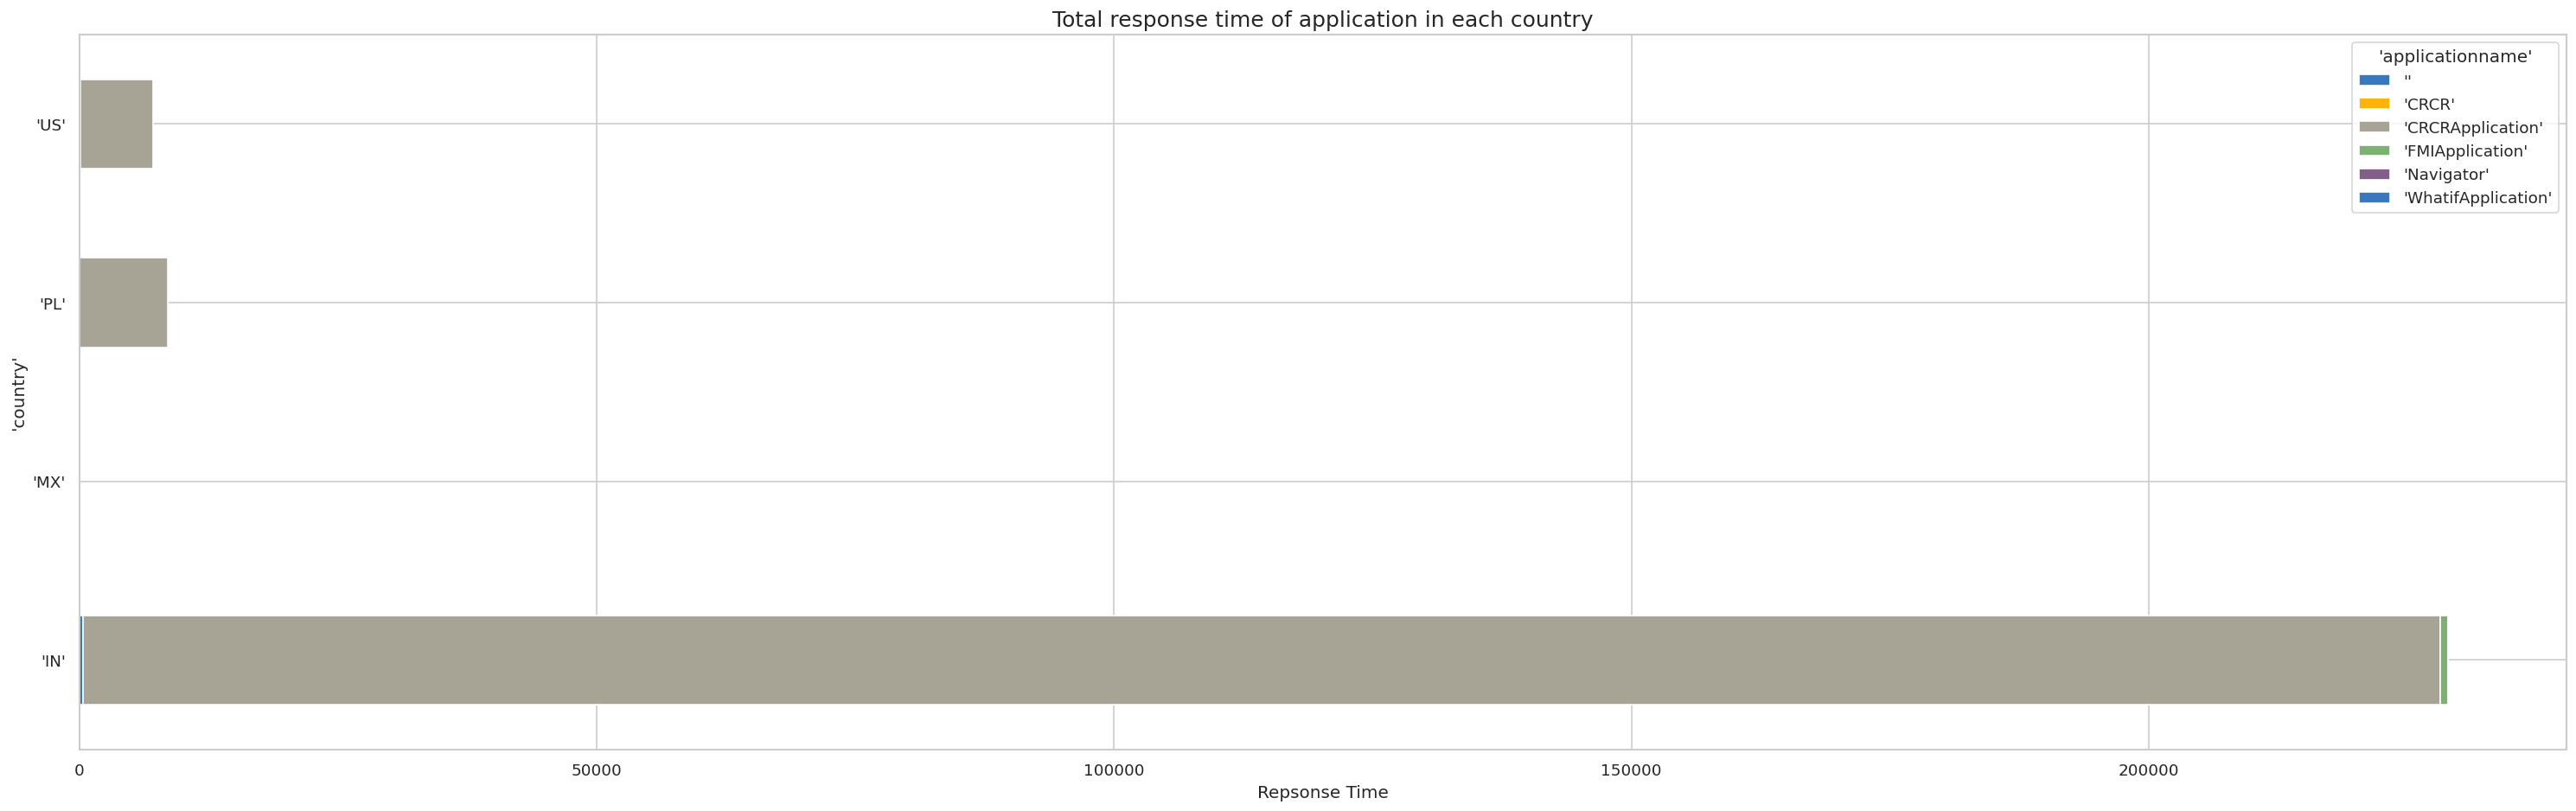

<Figure size 720x600 with 0 Axes>

In [247]:
df_raw.groupby(["'country'","'applicationname'"])["'responsetime'"].sum().unstack().fillna(0).plot(kind='barh',stacked=True,figsize=(25,8))
plt.xlabel('Repsonse Time')
plt.title('Total response time of application in each country',fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.clf()

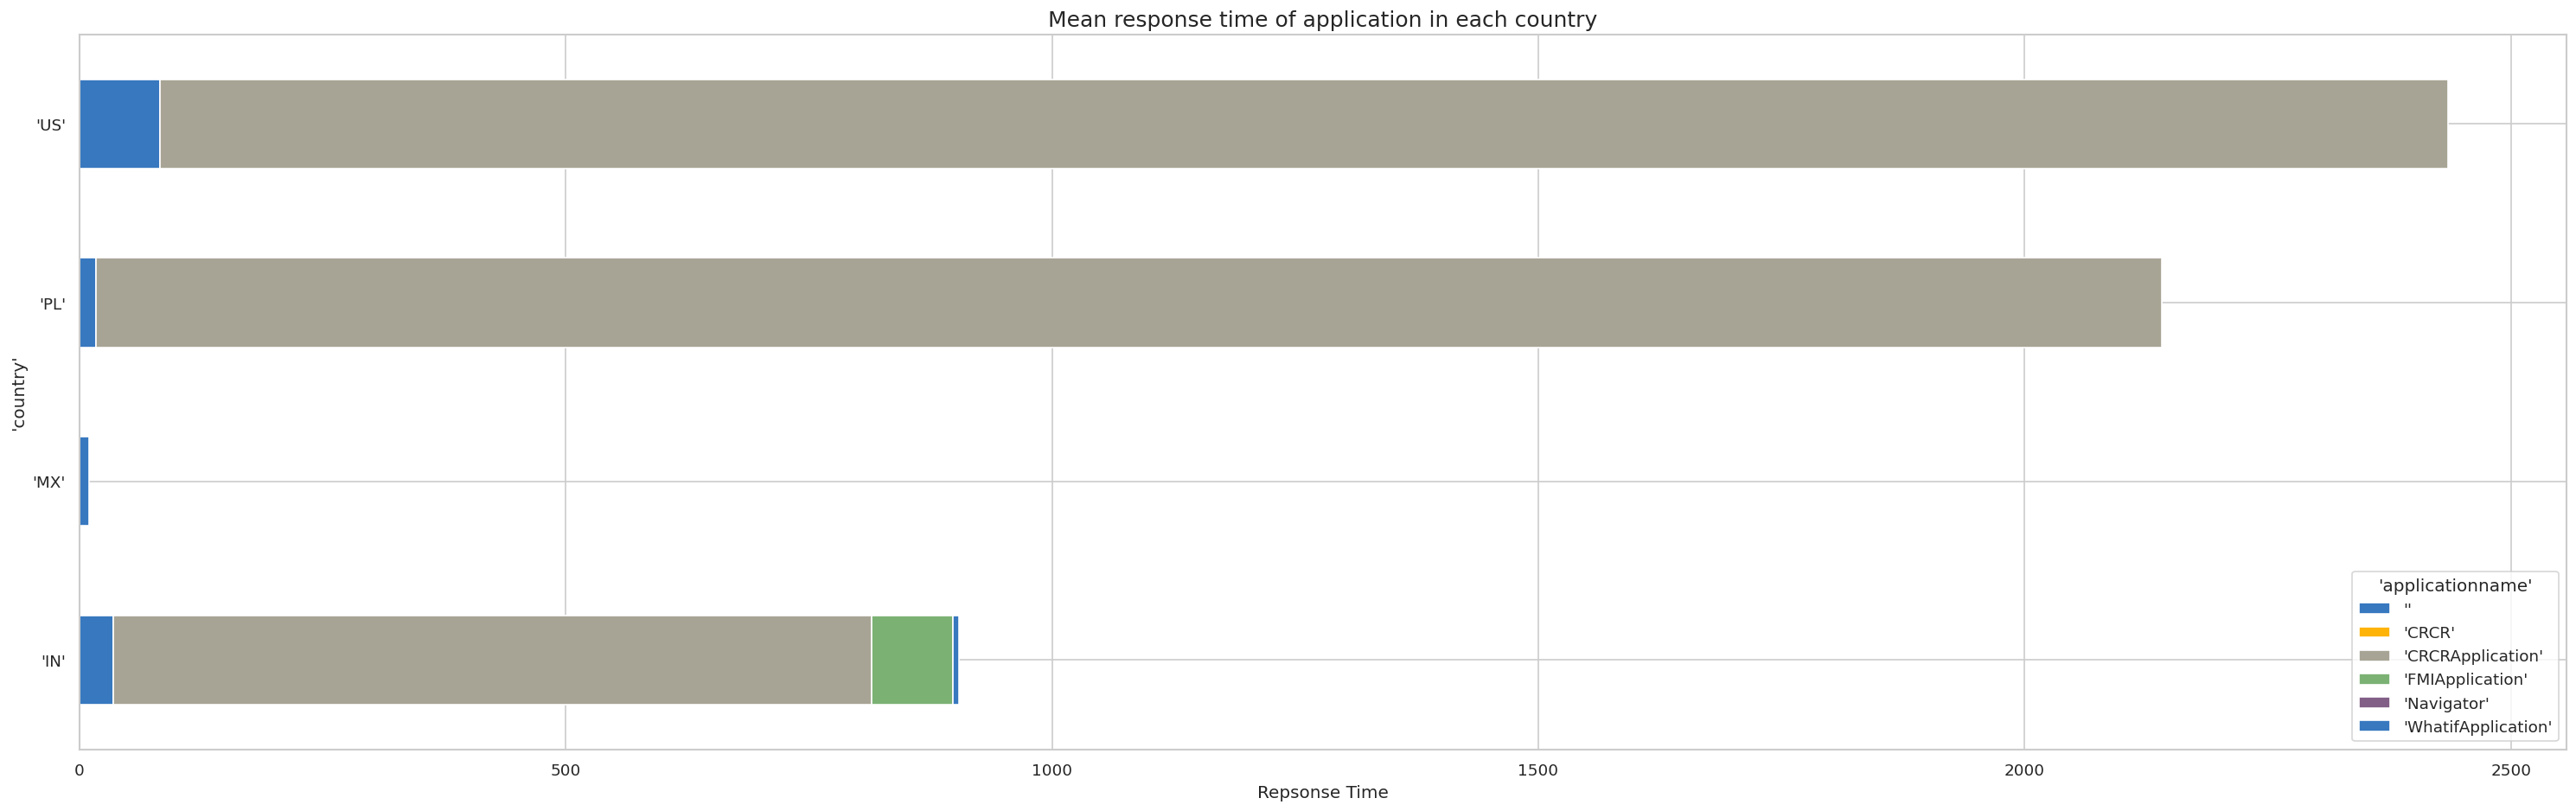

<Figure size 720x600 with 0 Axes>

In [248]:
df_raw.groupby(["'country'","'applicationname'"])["'responsetime'"].mean().unstack().fillna(0).plot(kind='barh',stacked=True,figsize=(25,8))
plt.xlabel('Repsonse Time')
plt.title('Mean response time of application in each country',fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.clf()

# Logged From

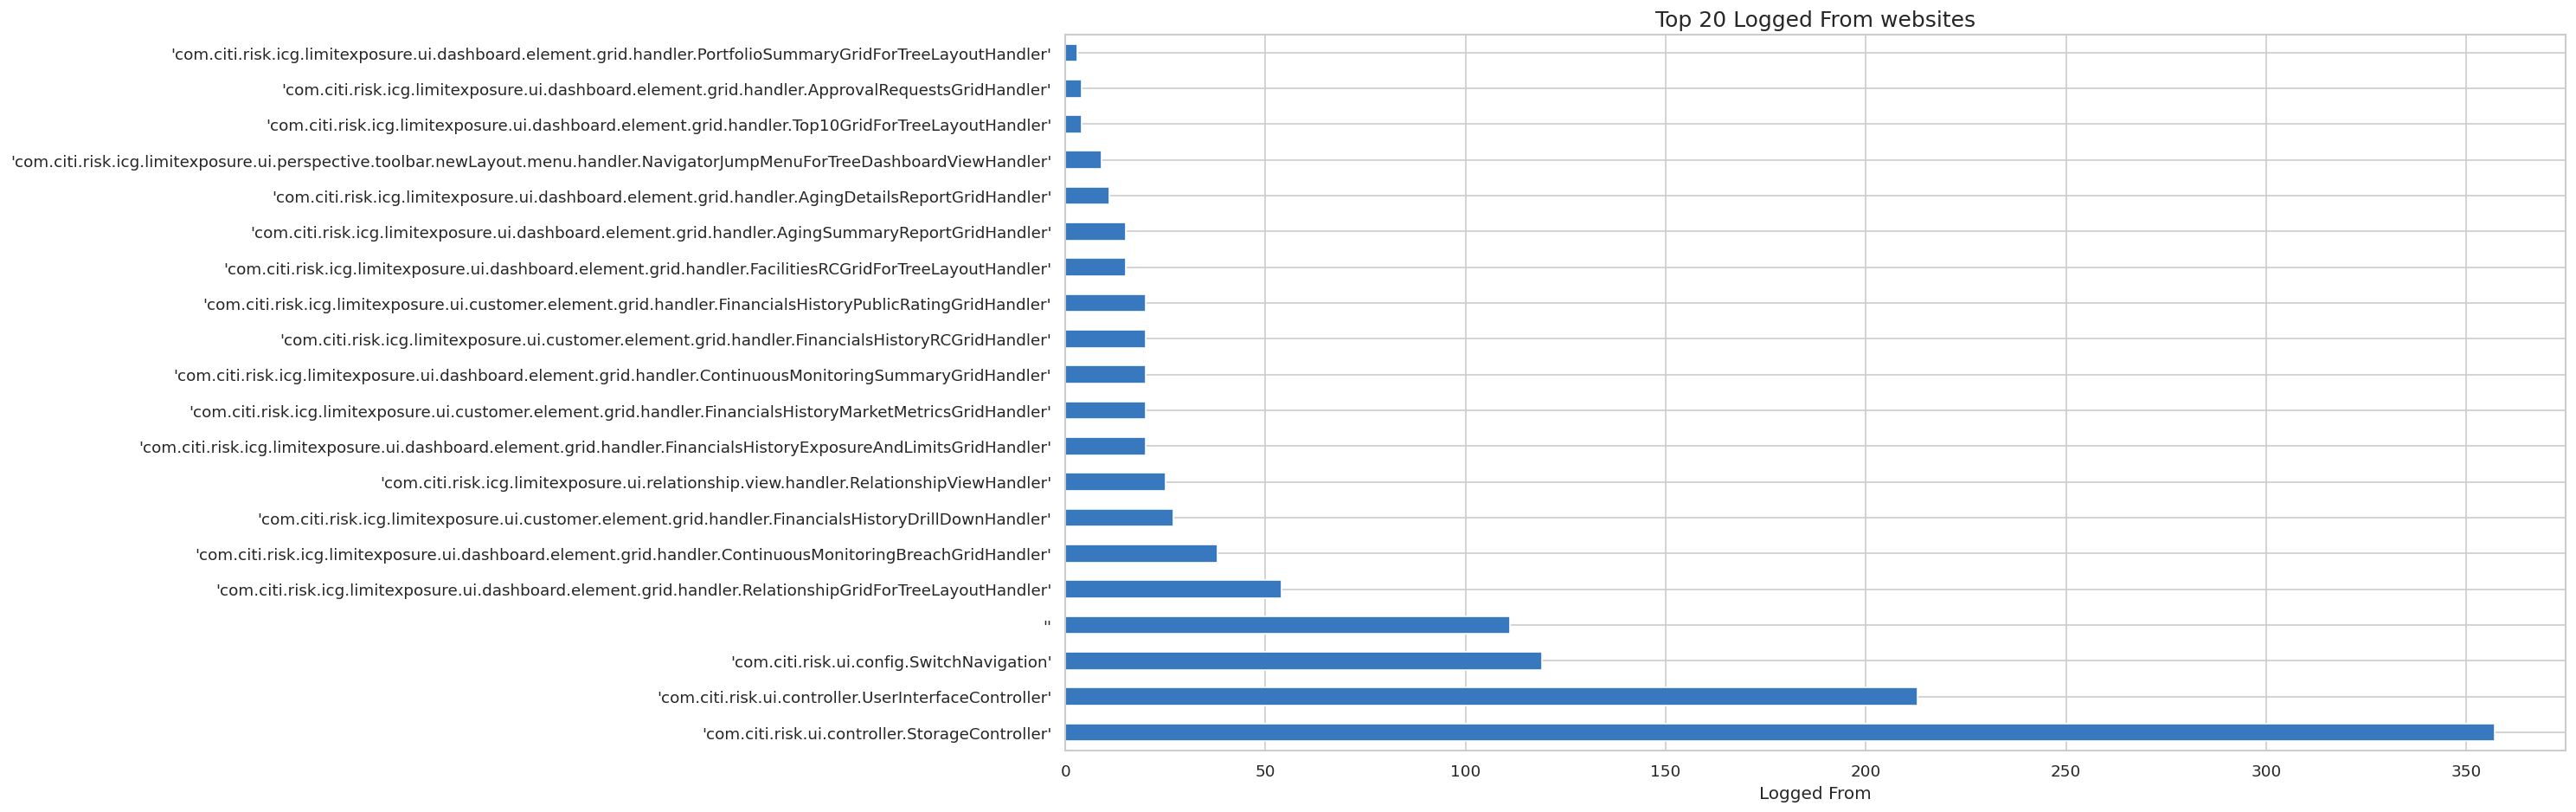

<Figure size 720x600 with 0 Axes>

In [249]:
df_raw["'loggedfrom'"].value_counts()[:20].sort_values(ascending=False).plot(kind='barh',figsize=(25,8))
plt.xlabel('Logged From')
plt.title('Top 20 Logged From websites',fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.clf()